**Ficheux et al, arXiv:2011.02634**

In this notebook we want to capture the basic effect behind the two-qubit gate for fluxonia described in the paper by Ficheux et al(2020) "Fast logic with slow qubits:microwave-activated controlled-Z gate on low-frequency fuxoniums"

In [16]:
import numpy as np
import sys
import time
import datetime
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import product, combinations
from IPython.display import display, Latex

%matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 5)

from IPython.display import display, HTML, Image

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

#%notify

<IPython.core.display.Javascript object>

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\frac{\hat{H}_{drive}}{h} = \left( \epsilon_A \hat{n}_A + \epsilon_B \hat{n}_B \right) \cos(2\pi f_d t)$$

# Single fluxonia
We take parameters as in Table 1 of the paper

In [2]:
# Values in GHz (divided by h)
#Fluxonium A
ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2#pi in the cos

# Fluxonium B 
ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

n_fock = 100

Let us first reproduce the other parameters in Table 1

In [3]:
levels = 5
flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels)
flx_b.diagonalize_basis(levels)
# If you run this twice it gives an error, so this has to be fixed in the source code

In [4]:
energies_a, eig_states_a = flx_a.eig_states(levels)
energies_b, eig_states_b = flx_b.eig_states(levels)
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^A = ' + str(energies_a[k + 1] - energies_a[k]) + ' GHz' )
    print('f_' + str(k) + str(k + 1) + '^B = ' + str(energies_b[k + 1] - energies_b[k]) + ' GHz' )
print('------')

------
f_01^A = 0.06987744707831667 GHz
f_01^B = 0.13833691129686648 GHz
------
f_12^A = 5.185077668515964 GHz
f_12^B = 4.922394350520492 GHz
------
f_23^A = 0.9905236831630644 GHz
f_23^B = 1.5308324694726387 GHz
------


<IPython.core.display.Javascript object>


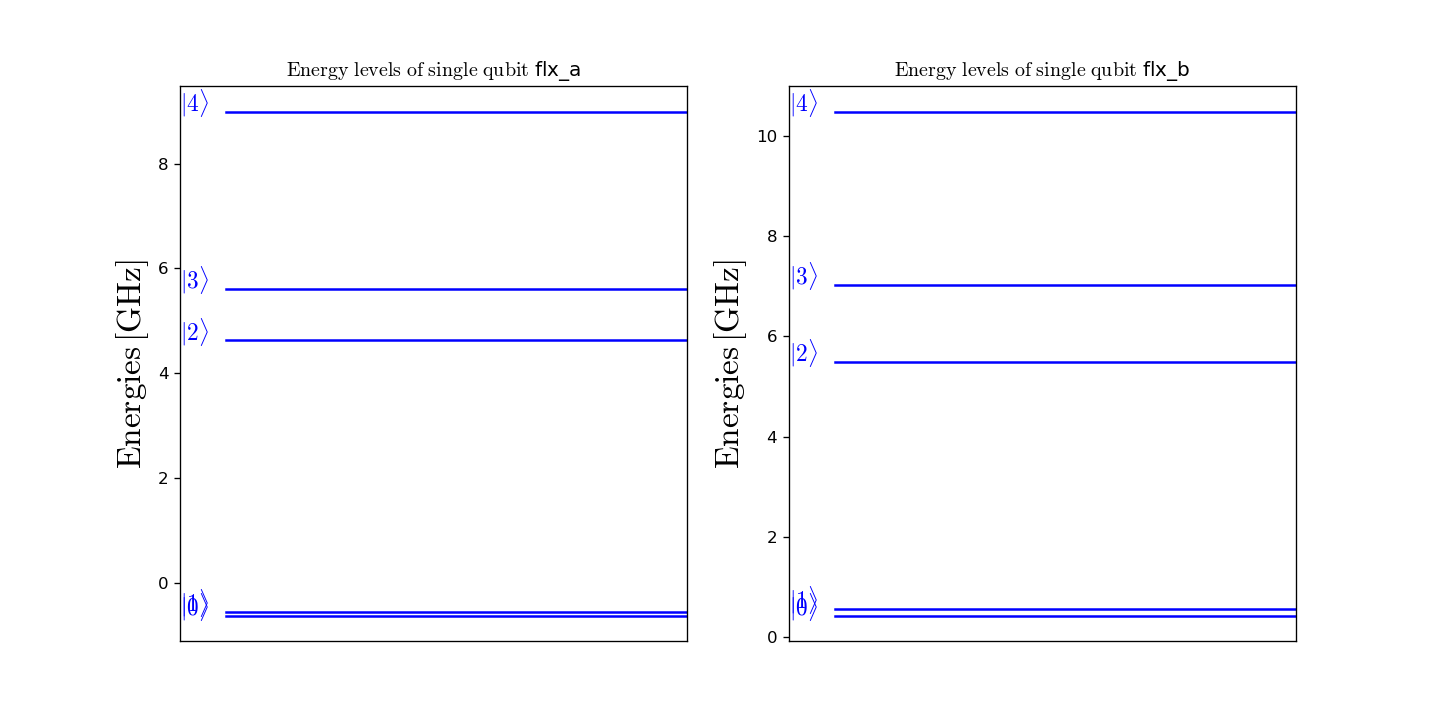

In [5]:
#plot les nvx d'énergie des a et b ide by side

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
text_lab = ["$| " + str(k) + " \\rangle $" for k in range(levels)]

def plot_energies_single(energies, text_lab, opt, name, ax):
    for k in range(0, levels):
        ax.plot([0,1], [energies[k]]*2, color='blue')
        ax.text(-0.1, energies[k], text_lab[k], fontsize=opt['fs_text'], color='blue')

    ax.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    ax.set_title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    ax.xaxis.set_visible(False)
    ax.set_xlim(-.1, 1)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_energies_single(energies_a, text_lab, opt, "flx_a",  ax[0])
plot_energies_single(energies_b, text_lab, opt, "flx_b",  ax[1])


Thus, we correctly recover the frequencies Table 1 in the paper. Notice that the eigenenergies are also divided by $h$ and so are intended as frequencies and not as angular velocities;

In [7]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^A| = ' + \
          str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[k], eig_states_a[k + 1]))))
    print('|n_' + str(k) + str(k + 1) + '^B| = ' + \
          str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[k], eig_states_b[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '^A| = '  + \
      str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[0], eig_states_a[3]))))
print('|n_' + str(0) + str(3) + '^B| = '  + \
      str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[0], eig_states_b[3]))))

------
|n_01^A| = 0.0253055781562991
|n_01^B| = 0.044713989127811764
------
|n_12^A| = 0.598101783710907
|n_12^B| = 0.5862083695927306
------
|n_03^A| = 0.585651023426629
|n_03^B| = 0.5522868863936361


We see that $n^{\alpha}_{0-1} \ll n^{\alpha}_{1-2}$ as predicted by Ficheux

<IPython.core.display.Javascript object>


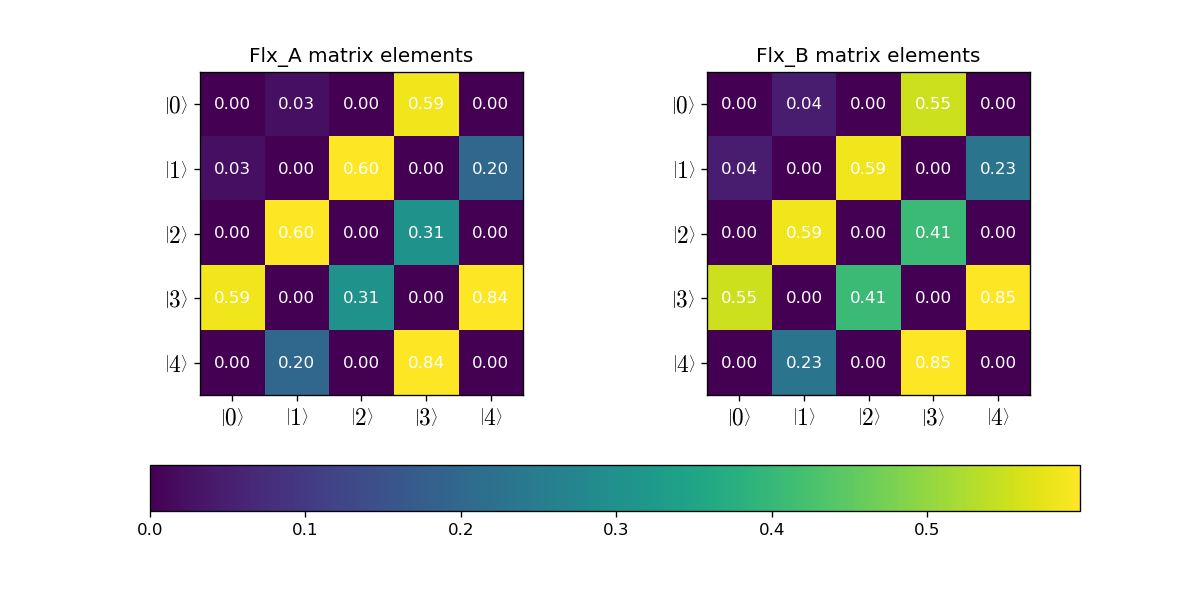

In [8]:
def plot_charge_op(flx, name, ax, vmin, vmax):
    lv = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = flx.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)

#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ima = plot_charge_op(flx_a, "Flx_A", ax[0], vmin, vmax)
imb = plot_charge_op(flx_b, "Flx_B", ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

In [9]:
energies_in_lexico = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_in_lexico[count] = energies_b[m] + energies_a[k]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)

label_converter = ascending_to_lexico
label_converter

array([ 0,  5,  1,  6,  2,  7, 10, 11, 15, 16,  3,  8, 20, 21,  4,  9, 12,
       17, 13, 18, 22, 14, 23, 19, 24], dtype=int64)

If $ \textit{ascending_to_lexico}[i] = j$ Then  $$i^{th}\mathrm{\ in \ ascending \ energies \ order \ is \ } j^{th} \mathrm{\ in \ lexicographic \ order}$$

In [10]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

# Coupled fluxonia

As a preliminary study, I want to plot the energy levels of the coupled system as a function of the coupling strength $J_C$. I take coupling strengths similar to those taken in the paper (see Fig. 2).

Expected Energy spectrum ($J_c = 224$ MHz) :
![](energy_levels.jpg)

## Role of J_c

In [48]:
n_points = 20
levels_plot = 8
jc_list = np.linspace(0, 0.4, n_points)
en_mat = np.zeros([levels_plot, n_points], dtype=float)
for k in range(0, n_points):
    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_list[k])
    en_mat[:, k] = coupled_flx.eig_energies(levels_plot)

<IPython.core.display.Javascript object>


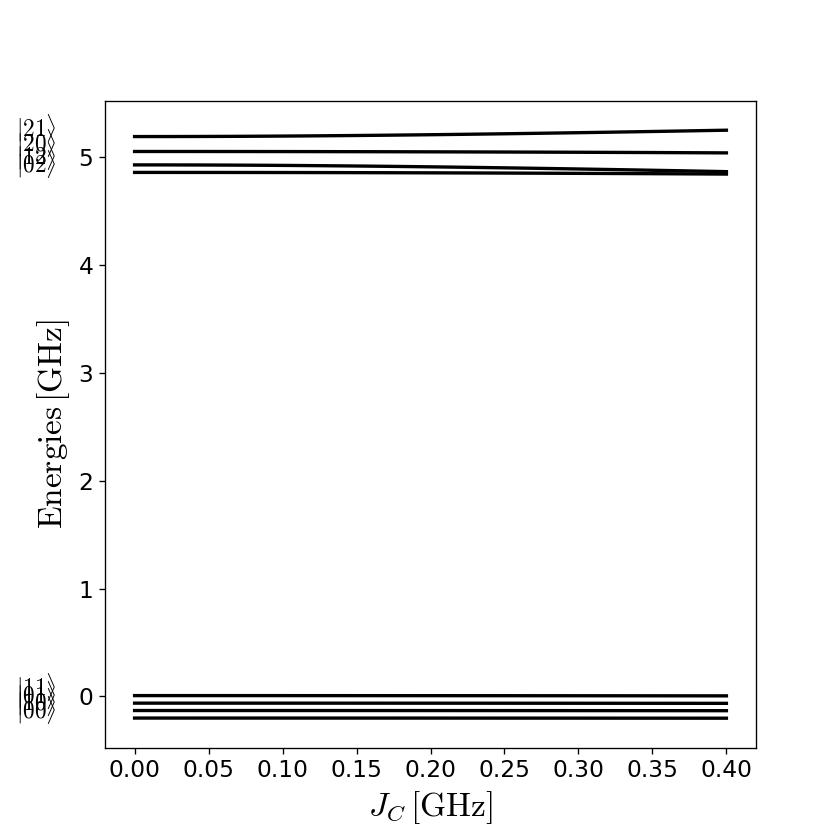

In [49]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_jc(
    en_mat: np.ndarray, 
    jc_list:np.ndarray, 
    opt:dict
) -> None:
    n_lev = en_mat.shape[0]
    fig, ax = plt.subplots(figsize=(7, 7))
    for k, m in [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]]:
        plt.plot(jc_list, [label_to_energies(k, m, levels, en_mat[:, ii], label_converter) for ii in range(len(jc_list))], 
             linewidth=opt['lw'], color='black')
        plt.text(-0.08, label_to_energies(k, m, levels, en_mat[:, 0], label_converter), 
                 "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')
        
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])

    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.show()
    
plot_energies_jc(en_mat, jc_list, plot_setup) 

## Coupling

In [81]:
jc = 0#0.224 #GHz (divided by h)

coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 

coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 

list_labelz = ["|00>", "|10>", "|01>", "|11>", \
                     "|02>", "|12>", "|20>", "|21>" ] #in ascending energy order

for k in range(len(list_labelz)):
    print(str(k)+"th energy level " + list_labelz[k] + " :  Bare : " + str(np.round(energies_bare[k], 4)) + 
                  "[GHz] || Interacting : " + str(np.round(energies_sys[k], 6)) + "[GHz]")

0th energy level |00> :  Bare : -0.2006[GHz] || Interacting : -0.200578[GHz]
1th energy level |10> :  Bare : -0.1307[GHz] || Interacting : -0.1307[GHz]
2th energy level |01> :  Bare : -0.0622[GHz] || Interacting : -0.062241[GHz]
3th energy level |11> :  Bare : 0.0076[GHz] || Interacting : 0.007637[GHz]
4th energy level |02> :  Bare : 4.8602[GHz] || Interacting : 4.860154[GHz]
5th energy level |12> :  Bare : 4.93[GHz] || Interacting : 4.930031[GHz]
6th energy level |20> :  Bare : 5.0544[GHz] || Interacting : 5.054377[GHz]
7th energy level |21> :  Bare : 5.1927[GHz] || Interacting : 5.192714[GHz]


<IPython.core.display.Javascript object>


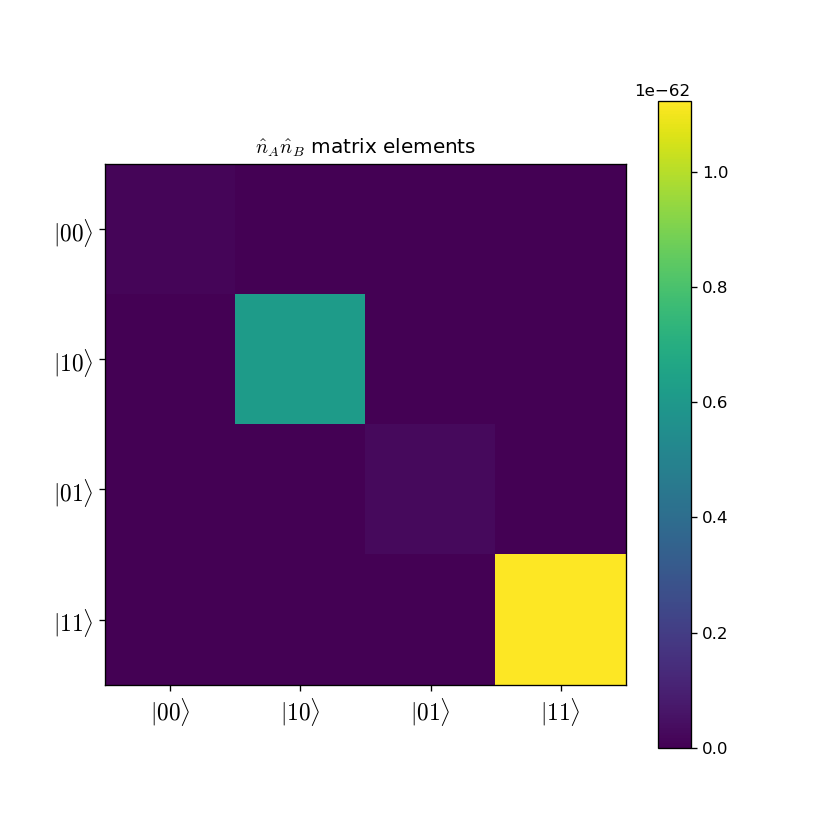

In [82]:
def plot_charge_op(opé, name, xmax, ymax):
    lvx = range(xmax)
    lvy = range(ymax)
    level_labels = ['$ |' + str(  np.argmax(np.abs(level))//levels  ) + \
                                str(  np.argmax(np.abs(level)) %levels  ) + '\\rangle $' for level in eigstates_sys]
    mat_elements = np.zeros((xmax, ymax))
    
    
    plt.figure(figsize = (7, 7))
    for a in range(xmax):
        for b in range(ymax):
            in_level = np.conj(eigstates_sys[a].T)
            out_level = eigstates_sys[b]
            mat_elements[a, b] = np.abs(in_level.dot(opé).dot(out_level))
#             plt.text(a, b, '{:.2f}'.format(float(mat_elements[a, b])), ha="center", va="center", color="white")


    plt.imshow(np.abs(mat_elements), cmap='viridis')            

    plt.xticks(ticks = lvx, labels = level_labels[:xmax], fontsize = 14)
    plt.yticks(ticks = lvy, labels = level_labels[:ymax], fontsize = 14)

    plt.title(name +  ' matrix elements')
    plt.colorbar()
    
    return mat_elements

n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
ope = n_a*n_b

_ = plot_charge_op(ope, "$\hat{n}_A \hat{n}_B$",4, 4)

## Energies and eigenvalues of H

<IPython.core.display.Javascript object>


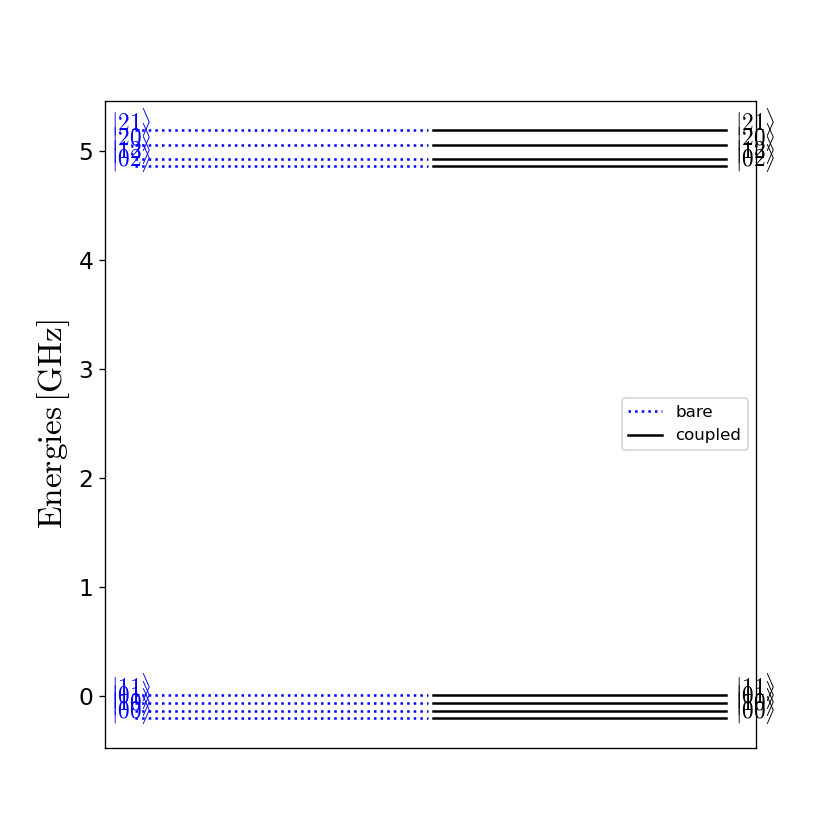

In [83]:
#Compare levels bare-int

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

plt.figure(figsize=(7, 7))
for k,m in [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]]:
    plt.plot([0,.99], [label_to_energies(k, m, levels, energies_bare, label_converter)]*2, 
             color='blue', linestyle = ':', label = "bare")
    plt.text(-0.08, label_to_energies(k, m, levels, energies_bare, label_converter), 
             "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='blue')

    plt.plot([1.01, 2], [label_to_energies(k, m, levels, energies_bare, label_converter)]*2, 
             color='black', label = "coupled")
    plt.text(+2.03,label_to_energies(k, m, levels, energies_bare, label_converter),
             "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')
    
    if (k, m)==(0, 0):
        plt.legend()
    
plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
plt.tick_params(axis='both', labelsize=opt['ls'])

frame1 = plt.gca()
frame1.axes.xaxis.set_visible(False)



# Drive

In [84]:
state00 = qtp.Qobj(inpt=  label_to_states(0, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state01 = qtp.Qobj(inpt=  label_to_states(0, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state10 = qtp.Qobj(inpt=  label_to_states(1, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state11 = qtp.Qobj(inpt=  label_to_states(1, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])

state02 = qtp.Qobj(inpt=  label_to_states(0, 2, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state12 = qtp.Qobj(inpt=  label_to_states(1, 2, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state20 = qtp.Qobj(inpt=  label_to_states(2, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state21 = qtp.Qobj(inpt=  label_to_states(2, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])

In [135]:
e_b = 0.03634
ratio_e = .9 #optimal according to paper
e_a = ratio_e * e_b
eta = [1,0]#[e_a, e_b]

n_a = qtp.tensor(flx_a.charge_op(as_qobj = True), qtp.qeye(flx_b.charge_op(as_qobj = True).dims[0]))
n_b = qtp.tensor(qtp.qeye(flx_a.charge_op(as_qobj = True).dims[0]), flx_b.charge_op(as_qobj = True))
n_charge = [n_a, n_b]

According to the paper we have :

$$\Omega_{11-21}  = \left| \epsilon_A \langle 11 | \hat{n}_A | 21 \rangle + \epsilon_B \langle 11 | \hat{n}_B | 21 \rangle \right|$$
$$\Omega_{10-20}  = \left| \epsilon_A \langle 10 | \hat{n}_A | 20 \rangle + \epsilon_B \langle 10 | \hat{n}_B | 20 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{11-21}}{\Omega_{10-20}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{11-21} - f_{10-20}$$
$$\delta = f_{11-21} - f_d$$

With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$

In [136]:
#we calculate rabi freq amplitudes :

rabi_10_20 = np.abs(eta[0] * (state10.dag() * n_charge[0] * state20).full()[0, 0] + \
                          eta[1] * (state10.dag() * n_charge[1] * state20).full()[0, 0] )

rabi_11_21 = np.abs(eta[0] * (state11.dag() * n_charge[0] * state21).full()[0, 0] + \
                          eta[1] * (state11.dag() * n_charge[1] * state21).full()[0, 0] )

rabi_ratio = rabi_11_21/rabi_10_20
print("r =", rabi_ratio)

ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
print("\ndelta/Delta =", ratio_delta)

r = 1.0000000000000002

delta/Delta = 0.5


In [137]:
big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
small_delta = big_delta * ratio_delta

freq_drive = energies_sys[7] - energies_sys[3] - small_delta

t_drive = 1/big_delta

print("Big Delta = ", big_delta)
print("small delta = ", small_delta)

print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')

Big Delta =  3.552713678800501e-15
small delta =  1.7763568394002505e-15

Drive frequency fd: 5.185077668515971 [GHz]


In [138]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
print('Rabi period: ' + str(rabi_period) + ' [ns]')

Rabi period: 281474976710656.0 [ns]


## best eta_b

In [195]:
eta_sur_eta = .9

def Omega1(eta_b):
    eta_a = eta_b * eta_sur_eta
    eta = [eta_a, eta_b]
    
    rabi_10_20 = np.abs(eta[0] * (state10.dag() * n_charge[0] * state20).full()[0, 0] + \
                              eta[1] * (state10.dag() * n_charge[1] * state20).full()[0, 0] )

    rabi_11_21 = np.abs(eta[0] * (state11.dag() * n_charge[0] * state21).full()[0, 0] + \
                              eta[1] * (state11.dag() * n_charge[1] * state21).full()[0, 0] )

    rabi_ratio = rabi_11_21/rabi_10_20
    
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
    
    big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_11_21**2 + small_delta**2)

def Omega2(eta_b):
    eta_a = eta_b * eta_sur_eta
    eta = [eta_a, eta_b]
        
    rabi_10_20 = np.abs(eta[0] * (state10.dag() * n_charge[0] * state20).full()[0, 0] + \
                              eta[1] * (state10.dag() * n_charge[1] * state20).full()[0, 0] )

    rabi_11_21 = np.abs(eta[0] * (state11.dag() * n_charge[0] * state21).full()[0, 0] + \
                              eta[1] * (state11.dag() * n_charge[1] * state21).full()[0, 0] )

    rabi_ratio = rabi_11_21/rabi_10_20
    
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
    
    big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_10_20**2 + (small_delta - big_delta)**2)

<IPython.core.display.Javascript object>


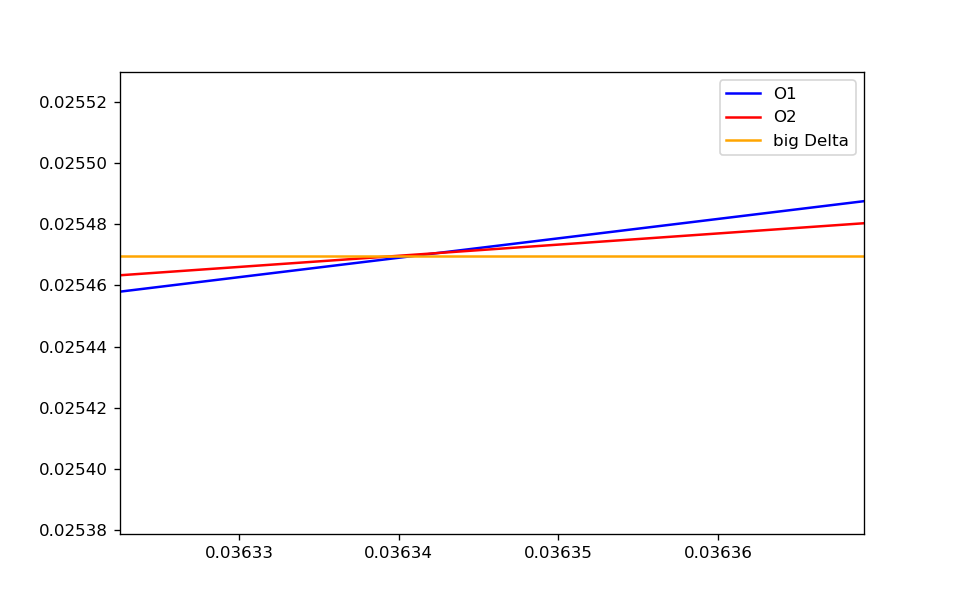

C:\Users\nicol\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Users\nicol\anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [197]:
rg_e_b = np.linspace(0, 1, 1000)

plt.figure()
plt.plot(rg_e_b, Omega1(rg_e_b), color = 'blue', label = 'O1')
plt.plot(rg_e_b, Omega2(rg_e_b), color = 'red', label = 'O2')
plt.plot(rg_e_b, [big_delta]*len(rg_e_b), color = 'orange', label = 'big Delta')

plt.legend()

#  Simulations

## Simu

We now want to perform simulations. The first task is to reproduce the two-photon Rabi oscillations and show that they reproduce correctly the Rabi period.

In [139]:
freq_drive = (energies_a[2] - energies_a[1])

In [140]:
#simulation setup (noiseless)
t_points = 5000
tps_simu =   2* 10 *2*np.pi #2*rabi_period*2*np.pi
tlist = np.linspace(0, tps_simu, t_points)

state_in = state10 + state11 #state00 + state01 + state10 + state11
rho_in = state_in*state_in.dag()

hamil0 = coupled_flx.hamiltonian(as_qobj=True)
hamil_drive = eta[0]*n_charge[0] + eta[1]*n_charge[1] 

pulse_drive = np.cos(freq_drive*tlist)

In [141]:
# Simulation run
result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

In [142]:
#for the following analysis :
#The order in phases, proj, probs... is as follows :
# 00 ; 01 ; 10 ; 11 ; 02 ; 12 : 20 : 21

labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]] ]

## Probs

In [143]:
#Def the other states

#and the rhos
rho_00 = state00*state00.dag()
rho_01 = state01*state01.dag()
rho_10 = state10*state10.dag()
rho_11 = state11*state11.dag()

rho_02 = state02*state02.dag()
rho_12 = state12*state12.dag()
rho_20 = state20*state20.dag()
rho_21 = state21*state21.dag()

probs = np.zeros([8, t_points], dtype=float)
for k in range(0, t_points):
    probs[0, k] = qtp.expect(rho_00, result.states[k]) 
    probs[1, k] = qtp.expect(rho_01, result.states[k]) 
    probs[2, k] = qtp.expect(rho_10, result.states[k]) 
    probs[3, k] = qtp.expect(rho_11, result.states[k]) 
    probs[4, k] = qtp.expect(rho_02, result.states[k])
    probs[5, k] = qtp.expect(rho_12, result.states[k])
    probs[6, k] = qtp.expect(rho_20, result.states[k])
    probs[7, k] = qtp.expect(rho_21, result.states[k])

<IPython.core.display.Javascript object>


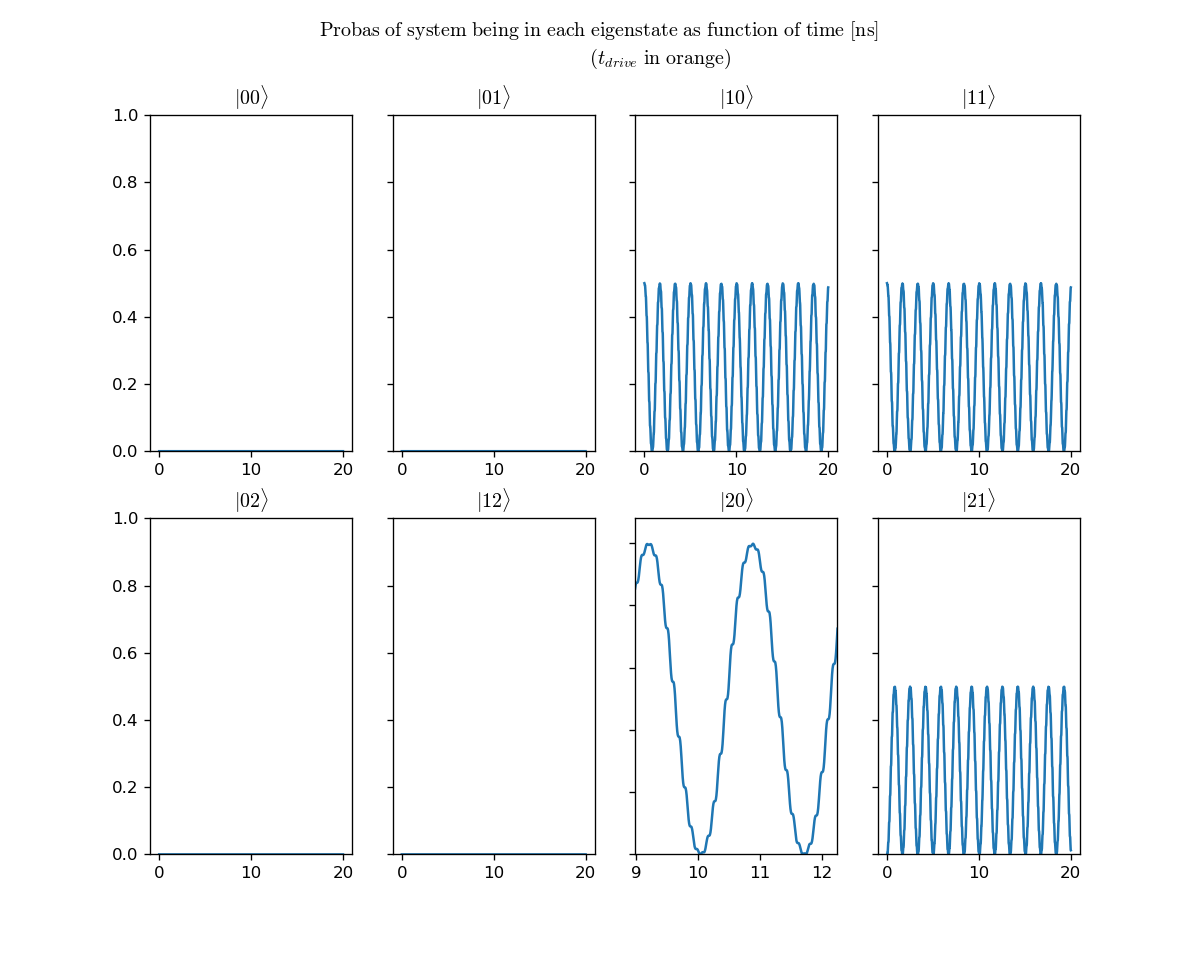

In [144]:
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    fig, ax = plt.subplots(2, 4, figsize = (10, 8))
    for k in range(0, 8):

        ax[k//4, k%4].plot(tlist, probs[k, :])
#         ax[k//levels, k%levels].plot([t_drive, t_drive], [0, 1])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k])
        
        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

        
    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                 each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                 $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    
        
plot_probas(tlist/(2*np.pi), probs, plot_setup)
    

In [145]:
1/rabi_10_20


1.6719562242324824

## Phases

In [227]:
#We get the phase of the 'projections' that once squared will give the probabilities
phases = np.zeros([8, t_points], dtype=float)
for k in range(0, t_points):
    phases[0, k] = cmath.phase((result.states[k].dag() * state00).full()[0,0])
    phases[1, k] = cmath.phase((result.states[k].dag() * state01).full()[0,0])
    phases[2, k] = cmath.phase((result.states[k].dag() * state10).full()[0,0])
    phases[3, k] = cmath.phase((result.states[k].dag() * state11).full()[0,0])
    phases[4, k] = cmath.phase((result.states[k].dag() * state02).full()[0,0])
    phases[5, k] = cmath.phase((result.states[k].dag() * state12).full()[0,0])
    phases[6, k] = cmath.phase((result.states[k].dag() * state20).full()[0,0])
    phases[7, k] = cmath.phase((result.states[k].dag() * state21).full()[0,0])                         
                               
# for i in range(8):
#     phases[i,:] -= phases[0,:]
                               

<IPython.core.display.Javascript object>


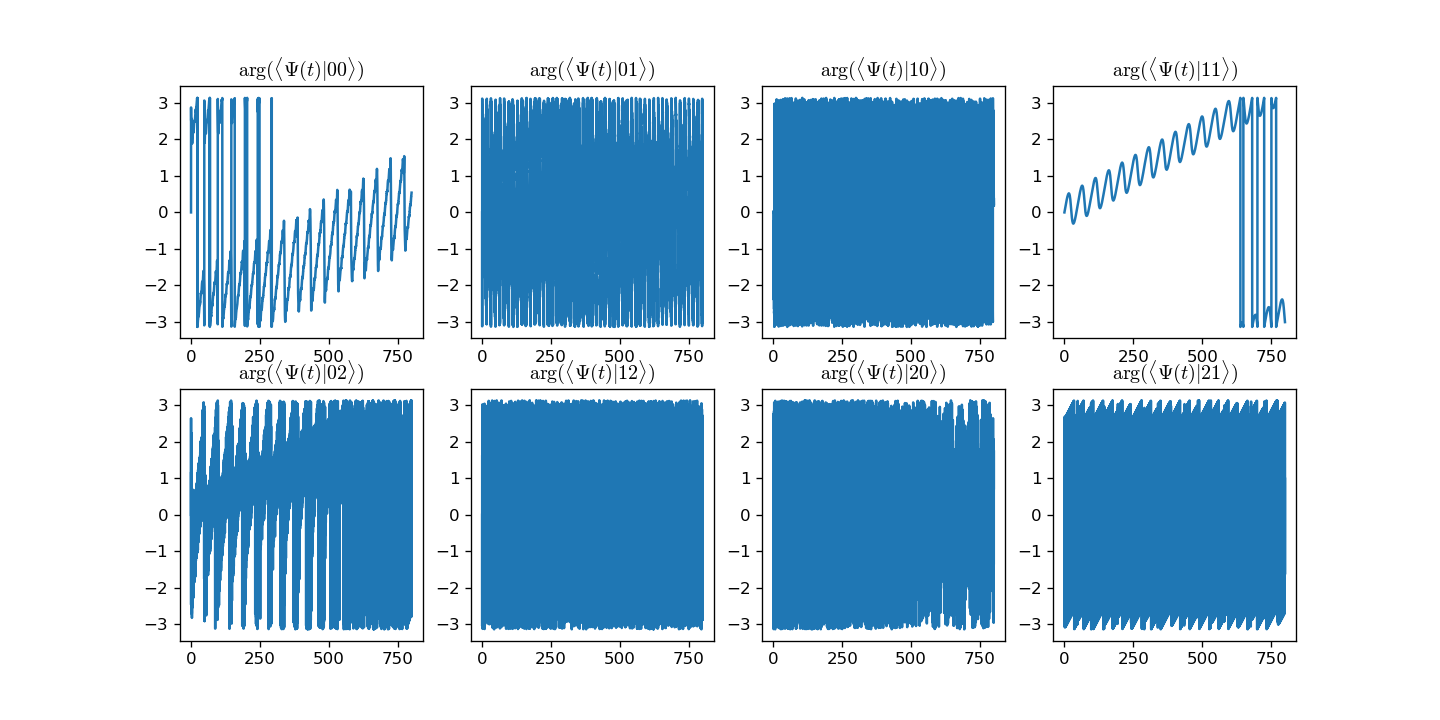

In [228]:
def plot_phases(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    fig, ax = plt.subplots(2, 4, figsize = (12, 6))
    for k in range(0, 8):

        ax[k//4, k%4].plot(tlist, probs[k, :])
#         ax[k//4, k%4].plot([t_drive, t_drive], [0, 1])

#         ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + labels[k] +"$)$")
        
#         if k%4 != 0:
#             ax[k//4, k%4].axes.yaxis.set_ticklabels([])

        
#     fig = plt.gcf()
#     fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
#                  each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
#                  $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    
        
plot_phases(tlist/(2*np.pi), phases, plot_setup)    

<IPython.core.display.Javascript object>


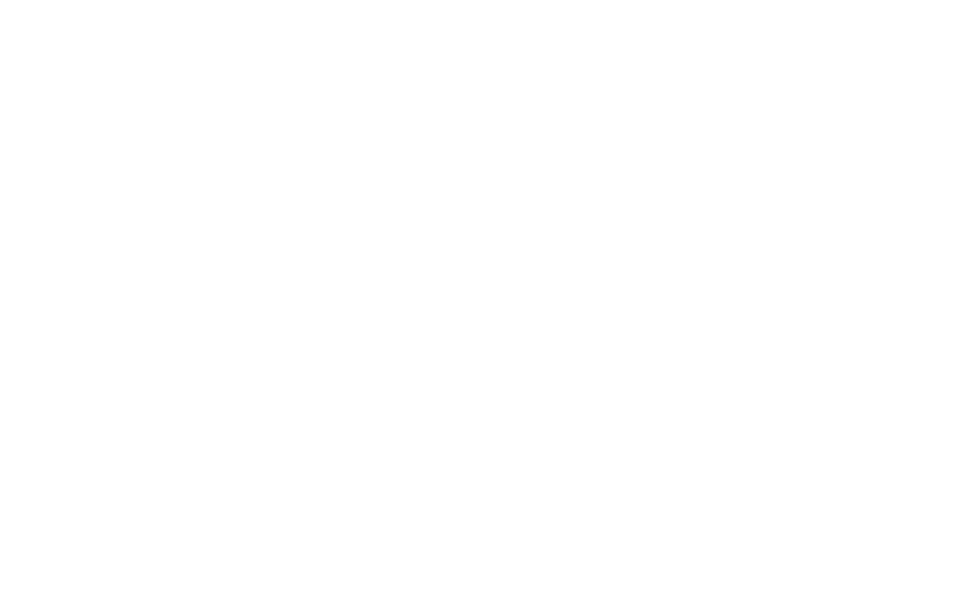

In [28]:
plt.figure()
plt.plot(tlist/(2*np.pi), (phases[3,:] - phases[1,:] - phases[2,:] - phases[0,:])  )

## Projections

<IPython.core.display.Javascript object>


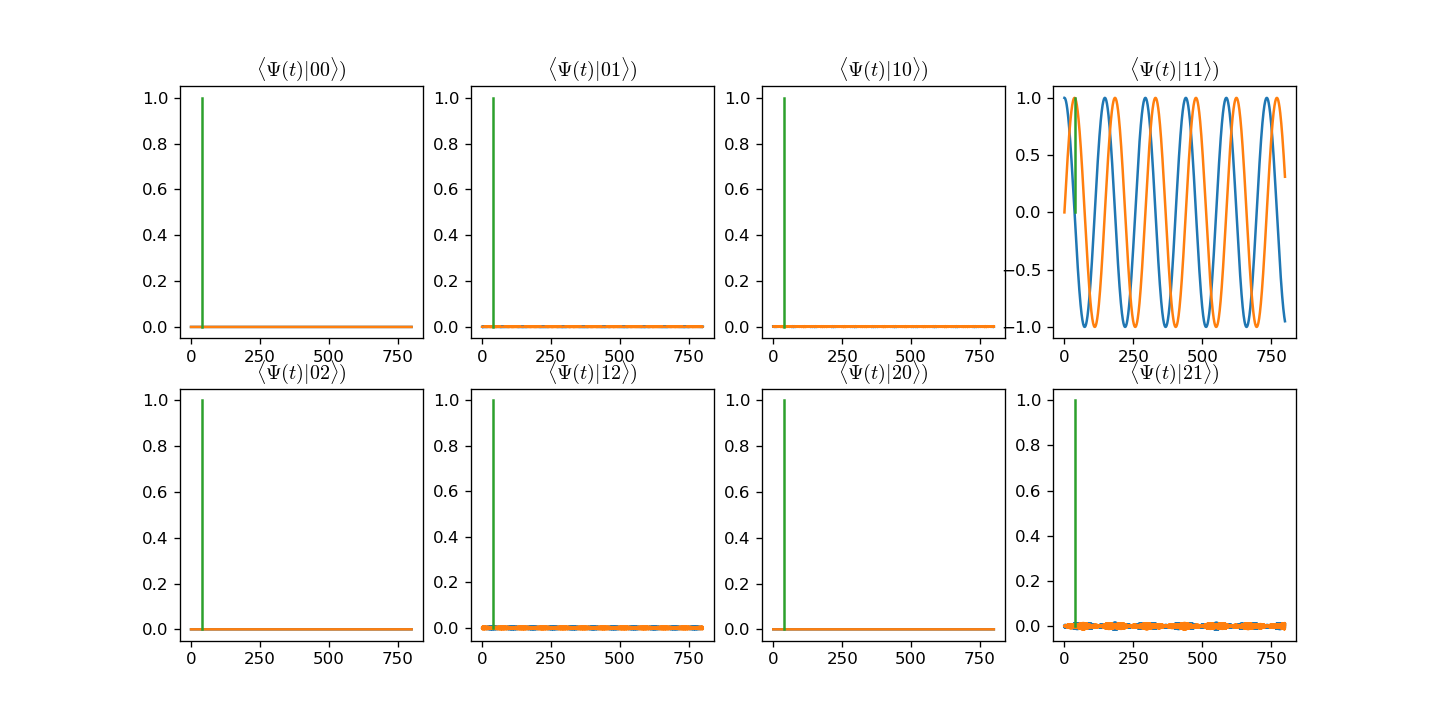

In [259]:
#only projections 

def plot_proj(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict,
    name = None
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    fig, ax = plt.subplots(2, 4, figsize = (12, 6))
    for k in range(0, 8):
        if name == 'all':
            ax[k//4, k%4].plot(tlist, probs[k, :].real)
            ax[k//4, k%4].plot(tlist, probs[k, :].imag)
        else :   
            ax[k//4, k%4].plot(tlist, probs[k, :])
            
        ax[k//4, k%4].plot([t_drive, t_drive], [0, 1])

#         ax[k//4, k%4].set_ylim(0, 1.0)
        if name == "all":
            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + labels[k] +"$)$")
        else :
            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + labels[k] +"$)$." + name)
        
#         if k%4 != 0:
#             ax[k//4, k%4].axes.yaxis.set_ticklabels([])

        
#     fig = plt.gcf()
#     fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
#                  each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
#                  $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    
    
    
proj = np.zeros([8, t_points], dtype=float)*1j
for k in range(0, t_points):
    proj[0, k] = (result.states[k].dag() * state00).full()[0,0]
    proj[1, k] = (result.states[k].dag() * state01).full()[0,0]
    proj[2, k] = (result.states[k].dag() * state10).full()[0,0]
    proj[3, k] = (result.states[k].dag() * state11).full()[0,0]
    proj[4, k] = (result.states[k].dag() * state02).full()[0,0]
    proj[5, k] = (result.states[k].dag() * state12).full()[0,0]
    proj[6, k] = (result.states[k].dag() * state20).full()[0,0]
    proj[7, k] = (result.states[k].dag() * state21).full()[0,0]                             
                               
# for i in range(8):
#     proj[i,:] /= proj[0,:]


# plot_proj(tlist/(2*np.pi), proj.real, plot_setup, name = "real")
# plot_proj(tlist/(2*np.pi), proj.imag, plot_setup, name = 'imag')

plot_proj(tlist/(2*np.pi), proj, plot_setup, name = 'all')

<IPython.core.display.Javascript object>


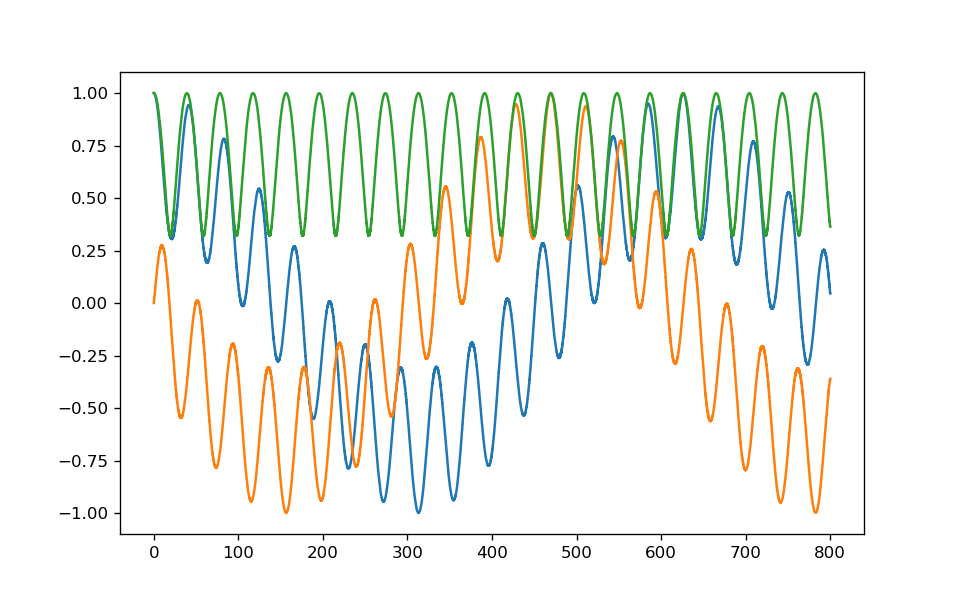

In [253]:
plt.figure()
plt.plot(tlist/(2*np.pi), proj[3,:].real)
plt.plot(tlist/(2*np.pi), proj[3,:].imag)
plt.plot(tlist/(2*np.pi), np.abs(proj[3,:]))

# Automatised test

(need to run the "single fluxonia" part first)

In [14]:
t_rise_best = 17.6
t_tot_best = 58.3
t_plateau_best = t_tot_best - 2*t_rise_best

print("The best times are : \nt_rise =", t_rise_best, "\nt_plateau =", t_plateau_best, "\nt_tot =", t_tot_best)

e_b_test = 0.03634
ratio_e_test = .9 #optimal according to paper
e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

The best times are : 
t_rise = 17.6 
t_plateau = 23.099999999999994 
t_tot = 58.3


## function body

In [37]:
def test_simu(jc, eta, list_init, freq_drive = None, freq_drive_trans = None,
              pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True,
              plot_spectrum = True,
             plot_proba = True, plot_phase = False, plot_proj = False, mute = False,
             figsize = (12, 6) ):

    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_sys, eigstates_sys = coupled_flx.eig_states() 
    
    coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
    energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 

    
    state00 = qtp.Qobj(inpt=  label_to_states(0, 0, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state01 = qtp.Qobj(inpt=  label_to_states(0, 1, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state10 = qtp.Qobj(inpt=  label_to_states(1, 0, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state11 = qtp.Qobj(inpt=  label_to_states(1, 1, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state02 = qtp.Qobj(inpt=  label_to_states(0, 2, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state12 = qtp.Qobj(inpt=  label_to_states(1, 2, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state20 = qtp.Qobj(inpt=  label_to_states(2, 0, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    state21 = qtp.Qobj(inpt=  label_to_states(2, 1, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
    
    if plot_spectrum:
        plt.figure(figsize=(7, 7))
        for k,m in [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]]:
            plt.plot([0,.99], [label_to_energies(k, m, levels, energies_bare, label_converter)]*2, 
                     color='blue', linestyle = ':', label = "bare")
            plt.text(-0.08, label_to_energies(k, m, levels, energies_bare, label_converter), 
                     "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='blue')

            plt.plot([1.01, 2], [label_to_energies(k, m, levels, energies_bare, label_converter)]*2, 
                     color='black', label = "coupled")
            plt.text(+2.03,label_to_energies(k, m, levels, energies_bare, label_converter),
                     "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')

            if k==0:
                plt.legend()

        plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
        plt.tick_params(axis='both', labelsize=opt['ls'])

        frame1 = plt.gca()
        frame1.axes.xaxis.set_visible(False)
        
    #construct drive parameters
    
    n_a = qtp.tensor(flx_a.charge_op(as_qobj = True), qtp.qeye(flx_b.charge_op(as_qobj = True).dims[0]))
    n_b = qtp.tensor(qtp.qeye(flx_a.charge_op(as_qobj = True).dims[0]), flx_b.charge_op(as_qobj = True))
    n_charge = [n_a, n_b]
    
    if not freq_drive_trans is None:
        freq_drive = energies_sys[freq_drive_trans[1]] - energies_sys[freq_drive_trans[0]]
        
    elif freq_drive is None:
        
        rabi_10_20 = np.abs(eta[0] * (state10.dag() * n_charge[0] * state20).full()[0, 0] + \
                                  eta[1] * (state10.dag() * n_charge[1] * state20).full()[0, 0] )
        rabi_11_21 = np.abs(eta[0] * (state11.dag() * n_charge[0] * state21).full()[0, 0] + \
                                  eta[1] * (state11.dag() * n_charge[1] * state21).full()[0, 0] )
        rabi_ratio = rabi_11_21/rabi_10_20

        ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)

        
        big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
        small_delta = ratio_delta*big_delta

        freq_drive = energies_sys[7] - energies_sys[3] - small_delta
        
        rabi_freq = big_delta
        rabi_period = 1/rabi_freq # [ns]
        
        t_drive = 1/big_delta
        
        if not mute:
            print("r =", rabi_ratio)
            print("\ndelta/Delta =", ratio_delta)
            print("\nBig Delta = ", big_delta)
            print("small delta = ", small_delta)

            print('\nRabi period: ' + str(rabi_period) + ' [ns]')
    if not mute:    
        print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')
    
    if plateau_time is None:
        plateau_time =  rabi_period
    simu_time = plateau_time
        
    if not rise_time is None:
        simu_time+= 2*rise_time
    
    nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
    tlist = np.linspace(0, simu_time*2*np.pi, nb_points)

    #state init : if int is present in list then eigstate[int] is in sum
    state_init = sum([tpl[0] * 
                      qtp.Qobj(inpt= label_to_states(tpl[1], tpl[2], levels, eigstates_sys, label_converter) , 
                               dims=[[levels, levels], [1, 1]], shape=[levels**2, 1]) for tpl in list_init])
    
    hamil0 = coupled_flx.hamiltonian(as_qobj=True)
    hamil_drive = eta[0]*n_charge[0] + eta[1]*n_charge[1] 
    
    if rise_time is None:
        pulse_drive = np.cos(freq_drive*tlist)
    else :
#         print("Custom drive")
        sigma = rise_time/(np.sqrt(2*np.pi))
        pulse_drive = np.zeros(len(tlist))
        for i in range(len(tlist)):
            t_i = tlist[i]/(2*np.pi)
            if t_i < rise_time:
                pulse_drive[i] = ( np.exp(-(t_i - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * np.cos(freq_drive*tlist[i])
            elif t_i < rise_time + plateau_time  :
                pulse_drive[i] = np.cos(freq_drive*tlist[i])
            else :
                pulse_drive[i] = ( np.exp(-(t_i - plateau_time - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * \
                                        np.cos(freq_drive*tlist[i])
    
    
    if with_drive :
        result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
    else :
        result = solvkit.integrate(tlist, state_init, hamil0, [], [], [], "mesolve")
        pulse_drive = np.zeros(len(tlist))
    
    #analysis:
    order = [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]]
    
    labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]] ]
    #the rhos
    rho_00 = state00*state00.dag()
    rho_01 = state01*state01.dag()
    rho_10 = state10*state10.dag()
    rho_11 = state11*state11.dag()

    rho_02 = state02*state02.dag()
    rho_12 = state12*state12.dag()
    rho_20 = state20*state20.dag()
    rho_21 = state21*state21.dag()
    
    #probas :
    probs = np.zeros([8, nb_points], dtype=float)
    for k in range(0, nb_points):
        probs[0, k] = qtp.expect(rho_00, result.states[k]) 
        probs[1, k] = qtp.expect(rho_01, result.states[k]) 
        probs[2, k] = qtp.expect(rho_10, result.states[k]) 
        probs[3, k] = qtp.expect(rho_11, result.states[k]) 
        probs[4, k] = qtp.expect(rho_02, result.states[k])
        probs[5, k] = qtp.expect(rho_12, result.states[k])
        probs[6, k] = qtp.expect(rho_20, result.states[k])
        probs[7, k] = qtp.expect(rho_21, result.states[k])
        
    #phases :
    phases = np.zeros([8, nb_points], dtype=float)
    for k in range(0, nb_points):
        phases[0, k] = (cmath.phase((result.states[k].dag() * state00).full()[0,0]) - \
                        ((label_to_energies(0, 0, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        phases[1, k] = (cmath.phase((result.states[k].dag() * state01).full()[0,0]) - \
                        ((label_to_energies(0, 1, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        phases[2, k] = (cmath.phase((result.states[k].dag() * state10).full()[0,0]) - \
                        ((label_to_energies(1, 0, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        phases[3, k] = (cmath.phase((result.states[k].dag() * state11).full()[0,0]) - \
                        ((label_to_energies(1, 1, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        phases[4, k] = (cmath.phase((result.states[k].dag() * state02).full()[0,0]) - \
                        ((label_to_energies(0, 2, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        phases[5, k] = (cmath.phase((result.states[k].dag() * state12).full()[0,0]) - \
                        ((label_to_energies(1, 2, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        phases[6, k] = (cmath.phase((result.states[k].dag() * state20).full()[0,0]) - \
                        ((label_to_energies(2, 0, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        phases[7, k] = (cmath.phase((result.states[k].dag() * state21).full()[0,0]) - \
                        ((label_to_energies(2, 1, levels, energies_bare, label_converter)*tlist[k])%(2*np.pi) - np.pi))

    phases = phases%(np.pi*2) - np.pi
    #projections
    proj = np.zeros([8, nb_points], dtype=float)*1j
    for k in range(0, nb_points):
        proj[0, k] = (result.states[k].dag() * state00).full()[0,0]
        proj[1, k] = (result.states[k].dag() * state01).full()[0,0]
        proj[2, k] = (result.states[k].dag() * state10).full()[0,0]
        proj[3, k] = (result.states[k].dag() * state11).full()[0,0]
        proj[4, k] = (result.states[k].dag() * state02).full()[0,0]
        proj[5, k] = (result.states[k].dag() * state12).full()[0,0]
        proj[6, k] = (result.states[k].dag() * state20).full()[0,0]
        proj[7, k] = (result.states[k].dag() * state21).full()[0,0]          
#     for i in range(8):
#         proj[i,:] /= proj[0,:]
        
    #plots :
    if plot_proba:
        fig, ax = plt.subplots(2, 4, figsize = figsize)
        for k in range(0, 8):
            ax[k//4, k%4].plot(tlist/(2*np.pi), probs[k, :])

            ax[k//4, k%4].set_ylim(0, 1.0)
            ax[k//4, k%4].set_title(labels[k])

            if k%4 != 0:
                ax[k//4, k%4].axes.yaxis.set_ticklabels([])
                
        fig = plt.gcf()
        fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                     each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                     $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
        
    if plot_phase:
        fig, ax = plt.subplots(2, 4, figsize = figsize)
        for k in range(0, 8):
            ax[k//4, k%4].plot(tlist/(2*np.pi), phases[k, :])
            ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + labels[k] +"$)$")
    
    if plot_proj:
        fig, ax = plt.subplots(2, 4, figsize = figsize)
        for k in range(0, 8):
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')
            ax[k//4, k%4].plot(tlist/(2*np.pi), np.abs(proj[k,:]), label = 'abs', linewidth = 1 , linestyle =  ":")

            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + labels[k] +"$)$")
            
            ax[k//4, k%4].set_ylim([-1,1])
            ax[k//4, k%4].legend()
            
            if k%4 != 0:
                    ax[k//4, k%4].axes.yaxis.set_ticklabels([])
            
    dict_res = {}
    dict_res['probs'] = probs
    dict_res['phases'] = phases
    dict_res['proj'] = proj
    dict_res['eigstates_sys'] = eigstates_sys
    dict_res['energies_sys'] = energies_sys
    dict_res['tlist'] = tlist
    dict_res['labels'] = labels
    dict_res['rabi_period'] = rabi_period
    dict_res['pulse_drive'] = pulse_drive
    dict_res['freq_drive'] = freq_drive
    
    return dict_res

## Tests with initialisation

In [30]:
e_b_test = 0.03634
ratio_e_test = .9 #optimal according to paper
e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

#increase eta
# eta_test = eta_test * 3

display( Latex('the Epsilons are : $\\varepsilon_A $ = %.4f and $\\varepsilon_B $ = %.4f ' % (e_a_test, e_b_test)))


#list init contains tuples, the first argument is factor in the sum, second and third give state of flx_a and flx_b
list_init = [[1, 0, 0],  
             [1, 0, 1],
             [1, 1, 0],
             [1, 1, 1]]

deb = time.time()

#R) For 60ns -> 1000 points is good (maybe a little more)
dict_res = test_simu(jc = .224, 
                      eta = eta_test,
                      list_init = list_init,
                      freq_drive = None,
                      freq_drive_trans = None,
                      plateau_time = 23.1,
                      rise_time = 17.6,
                      with_drive = True,
                      plot_spectrum = False,
                      plot_proba = True, 
                      plot_phase = True, 
                      plot_proj = False,
                      mute = False,
                      pts_per_drive_period = 15,
                      figsize = (12, 6))


print("It took ", time.time() - deb , "seconds")
#R) The order in phases, proj, probs... is as follows :
# 00 ; 01 ; 10 ; 11 ; 02 ; 12 : 20 : 21
print("The order in proj, probs, phases, ... is as follows :")
print(dict_res['labels'])

<IPython.core.display.Latex object>

r = 1.3199903366213783

delta/Delta = 0.30704956167928665

Big Delta =  0.02546960120165842
small delta =  0.00782042988511545

Rabi period: 39.26249147296764 [ns]

Drive frequency fd: 5.199158795956893 [GHz]
4546


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It took  10.410000324249268 seconds
The order in proj, probs, phases, ... is as follows :
['$| 00 \\rangle $', '$| 01 \\rangle $', '$| 10 \\rangle $', '$| 11 \\rangle $', '$| 02 \\rangle $', '$| 12 \\rangle $', '$| 20 \\rangle $', '$| 21 \\rangle $']


In [35]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['pulse_drive'])
# plt.plot(np.cos(dict_res['tlist'] * dict_res['freq_drive']))

#R) Weird shape could be liked to number of points too low (ie not enought points per period of the drive) 
#(the period of the drive is about .2 so there should be more than 50*(total time) points ie : for 60ns -> 3000pts at least)

<IPython.core.display.Javascript object>

In [47]:
ind = 7

plt.figure(figsize = (12, 7))
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['proj'][ind].real, label = 'real')
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['proj'][ind].imag, label = 'imag')
plt.plot(dict_res['tlist']/(2*np.pi), np.abs(dict_res['proj'][ind]), label = 'abs', linewidth = 1 , linestyle =  ":")

plt.ylabel("$ \langle \Psi (t) $" + dict_res['labels'][ind] +"$)$")
plt.xlabel('$t$')
plt.legend()

<IPython.core.display.Javascript object>

## Tests for $\Delta \varphi$  (automatised)

In [156]:
def delta_phi_same_simu(jc, eta, freq_drive = None, freq_drive_trans = None,
               pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True,
               plot_spectrum = False,plot_proba = False, plot_phase = False, plot_proj = False, plot_phase_cond = True,
                mute = True, figsize = (12, 6)):
    
    dict_11_10 = test_simu(jc = jc, 
                              eta = eta,
                              list_init = [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]],
                              freq_drive = freq_drive,
                              freq_drive_trans = freq_drive_trans,
                              plateau_time = plateau_time,
                              rise_time = rise_time,
                              with_drive = with_drive,
                              plot_spectrum = plot_spectrum,
                              plot_proba = plot_proba, 
                              plot_phase = plot_phase, 
                              plot_proj = plot_proj,
                              mute = mute,
                              pts_per_drive_period = pts_per_drive_period,
                              figsize = figsize)

    dphi = dict_11_10['phases'][3] - dict_11_10['phases'][2] - dict_11_10['phases'][1] + dict_11_10['phases'][0]  
#     dphi = (dphi % (2*np.pi)) #- np.pi
    
#     if not mute:
# #         print("The last value of Delta Phi is ", dphi[-1])
    
    if plot_phase_cond:
        plt.figure(figsize = figsize)

        plt.plot(dict_11_10['tlist']/(2*np.pi), dphi/np.pi)
        plt.title("$\Delta \\varphi (t) = \mathrm{arg}( \langle \Psi (t) | 11 \\rangle ) - \mathrm{arg}( \langle \Psi (t) | 10 \\rangle ) \
                  - \mathrm{arg}( \langle \Psi (t) | 01 \\rangle ) - \mathrm{arg}( \langle \Psi (t) | 00 \\rangle )$")

        plt.xlabel('$\mathrm{t}$')
        plt.ylabel('$\Delta \\varphi / \pi$')

    return dict_11_10['tlist'], dphi, dict_11_10

<IPython.core.display.Latex object>

r = 1.3199903366213783

delta/Delta = 0.30704956167928665

Big Delta =  0.02546960120165842
small delta =  0.00782042988511545

Rabi period: 39.26249147296764 [ns]

Drive frequency fd: 5.199158795956893 [GHz]


<IPython.core.display.Javascript object>


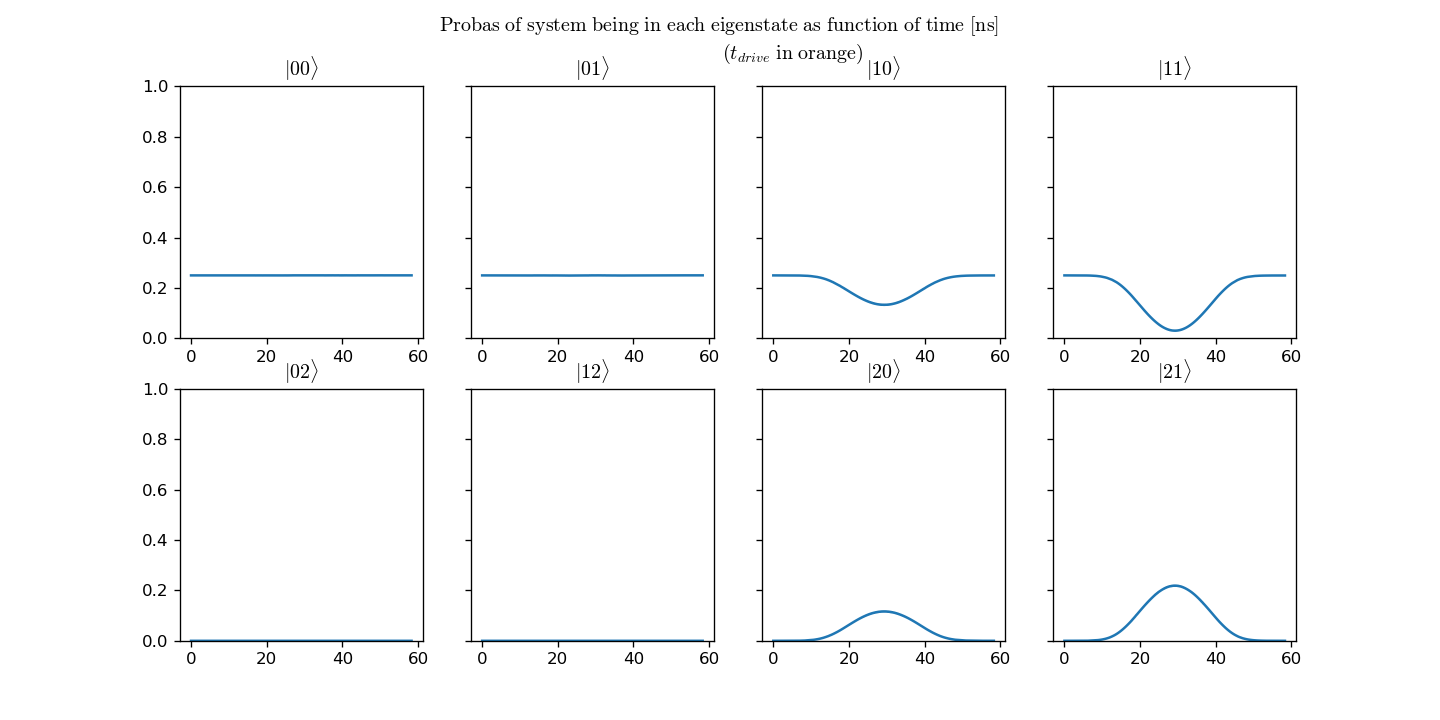

<IPython.core.display.Javascript object>


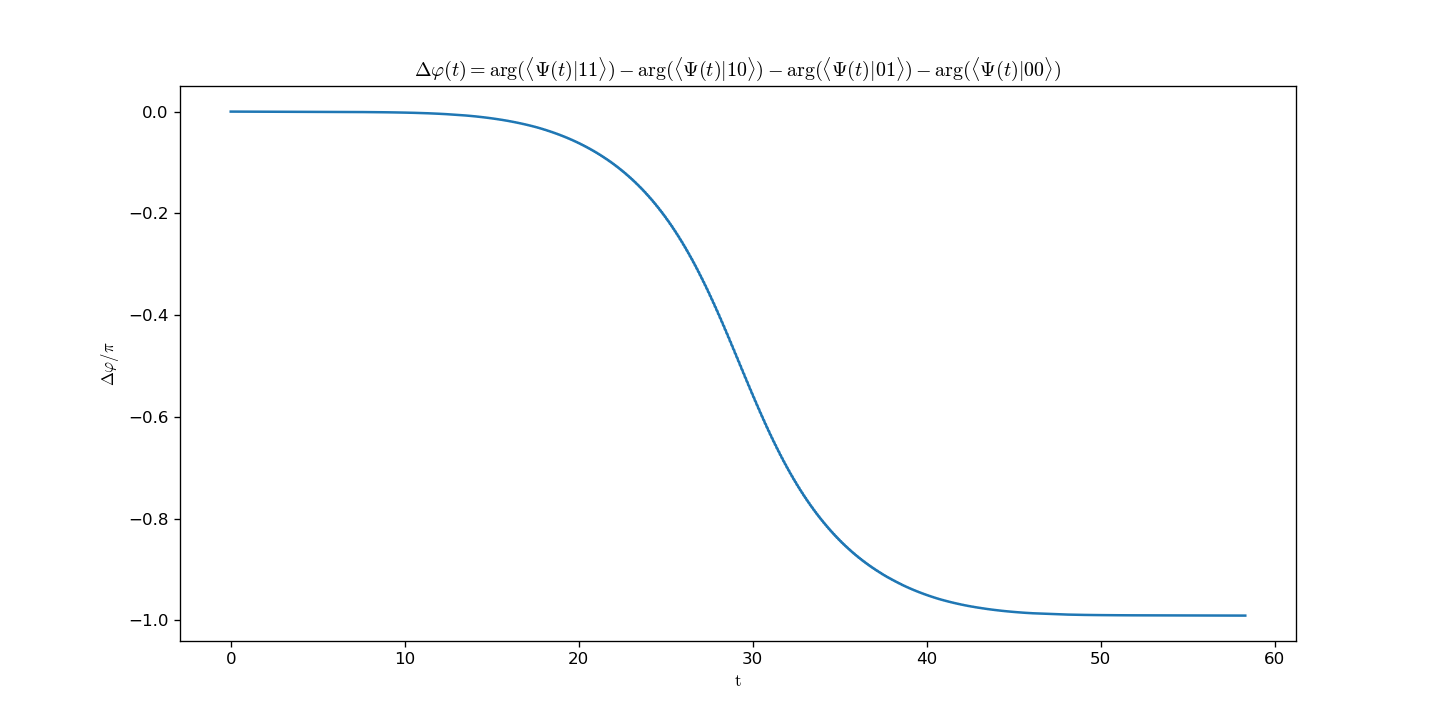

It took  14.069620132446289 seconds
The order in proj, probs, phases, ... is as follows :
['$| 00 \\rangle $', '$| 01 \\rangle $', '$| 10 \\rangle $', '$| 11 \\rangle $', '$| 02 \\rangle $', '$| 12 \\rangle $', '$| 20 \\rangle $', '$| 21 \\rangle $']


In [171]:
e_b_test = 0.03634
ratio_e_test = .9 #optimal according to paper
e_a_test = ratio_e_test * e_b_test
eta_test = np.array([e_a_test, e_b_test])

display( Latex('the Epsilons are : $\\varepsilon_A $ = %.4f and $\\varepsilon_B $ = %.4f ' % (e_a_test, e_b_test)))

#R) For 60ns -> 1000 points is good (maybe a little more)
deb = time.time()
tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                  eta = eta_test,
                                  freq_drive = None,
                                  freq_drive_trans = None,
                                  plateau_time = 23.1,
                                  rise_time = 17.6,
                                  with_drive = True,
                                  pts_per_drive_period = 20,
                                  plot_spectrum = False,
                                  plot_proba = True, 
                                  plot_phase = False, 
                                  plot_proj = False, 
                                  plot_phase_cond = True,
                                  mute = False,
                                  figsize = (12, 6))

print("It took ", time.time() - deb , "seconds")
#R) The order in phases, proj, probs... is as follows :
# 00 ; 01 ; 10 ; 11 ; 02 ; 12 : 20 : 21
print("The order in proj, probs, phases, ... is as follows :")
print(dict_res['labels'])

In [172]:
tlist = tlist/(2*np.pi)

extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
final_phase_in_pi = dphi[-1]/np.pi
proba_11_at_end = dict_res['probs'][3][-1]
    

# print("time after max in proba of 11 = ", extra_time, "ns")  #must go to 0
print("final_phase = ", final_phase_in_pi, "(in unit of pi) ")  #must go to pi (or -pi)
print("(proba of being in 11 at the end) / (proba of 11 at beginning) = ", dict_res['probs'][3][-1]/dict_res['probs'][3][0] )


final_phase =  -0.9907727408338005 (in unit of pi) 
(proba of being in 11 at the end) / (proba of 11 at beginning) =  0.9985246157393903


<IPython.core.display.Javascript object>


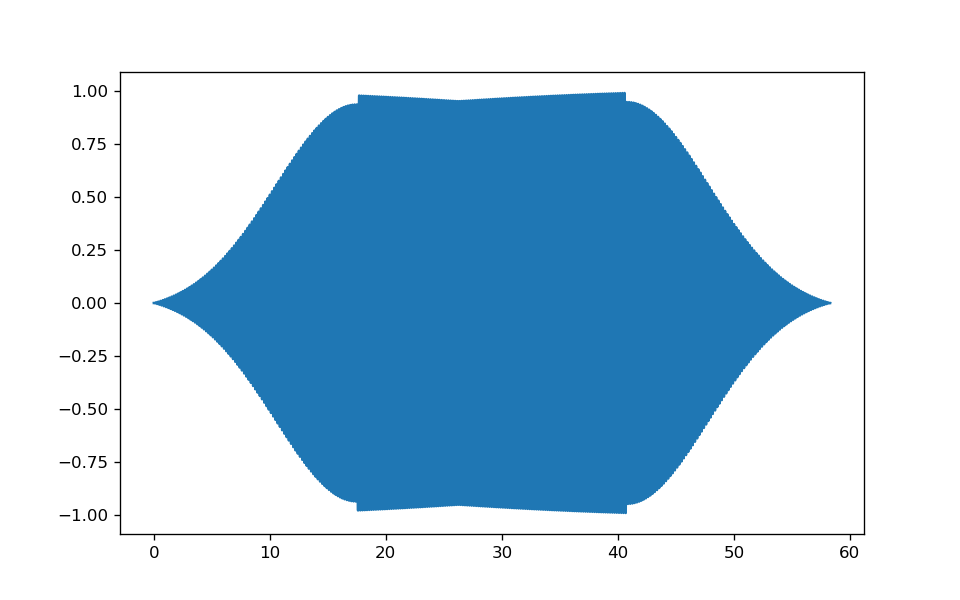

In [167]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['pulse_drive'])

## Tweak t_rise and t_plateau (manual)

In [292]:
#function to optimize :
e_b_test = 0.03634
ratio_e_test = .9 #optimal according to paper
e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

display( Latex('the Epsilons are : $\\varepsilon_A $ = %.4f and $\\varepsilon_B $ = %.4f ' % (e_a_test, e_b_test)))

def optim_drive(t_rise, t_plateau, plot_proba = False, plot_phase_cond = False, mute = True):
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                      eta = eta_test,
                                      freq_drive = None,
                                      freq_drive_trans = None,
                                      plateau_time = t_plateau,
                                      rise_time = t_rise,
                                      with_drive = True,
                                      pts_per_drive_period = 15,
                                      plot_spectrum = False,
                                      plot_proba = plot_proba, 
                                      plot_phase = False, 
                                      plot_proj = False, 
                                      plot_phase_cond = plot_phase_cond,
                                      figsize = (12, 6),
                                      mute = mute)
    tlist = tlist/(2*np.pi)

    
    
    extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    final_phase = dphi[-1]
    max_11_near_end = np.max(dict_res['probs'][3][2*len(tlist)//3 :])
    
#     print("It took ", time.time() - deb , "seconds")
#     print("time after max in proba of 11 : ", extra_time, "ns")  #must go to 0
#     print("final_phase : ", final_phase)  #must go to pi (or -pi)
    
    return extra_time, final_phase, max_11_near_end

<IPython.core.display.Latex object>

### 2D scann

In [226]:
#scann of t_rise and t_plateau
n_rise = 7
rg_t_rise = np.linspace(10, 20, n_rise)

n_plateau = 7
rg_t_plateau = np.linspace(15, 50, n_plateau)

scann_extra_times = np.zeros((n_rise, n_plateau))
scann_phases = np.zeros((n_rise, n_plateau))
scann_max_11 = np.zeros((n_rise, n_plateau))

deb_test = time.time()
optim_drive(np.mean(rg_t_rise), np.mean(rg_t_plateau))
length_test = time.time() - deb_test
print("Loops should take ", length_test*n_rise*n_plateau, "seconds  ; End around", 
              datetime.datetime.now() + datetime.timedelta(seconds = length_test*n_rise*n_plateau))

Loops should take  559.9243924617767 seconds  ; End around 2021-06-03 13:02:25.702228


In [227]:
for a in range(n_rise):
    for b in range(n_plateau):
        scann_extra_times[a,b], scann_phases[a,b], scann_max_11[a,b] = optim_drive(rg_t_rise[a], rg_t_plateau[b])

In [228]:
%notify

<IPython.core.display.Javascript object>

In [229]:
scann_phases_abs = np.abs(scann_phases)

<IPython.core.display.Javascript object>


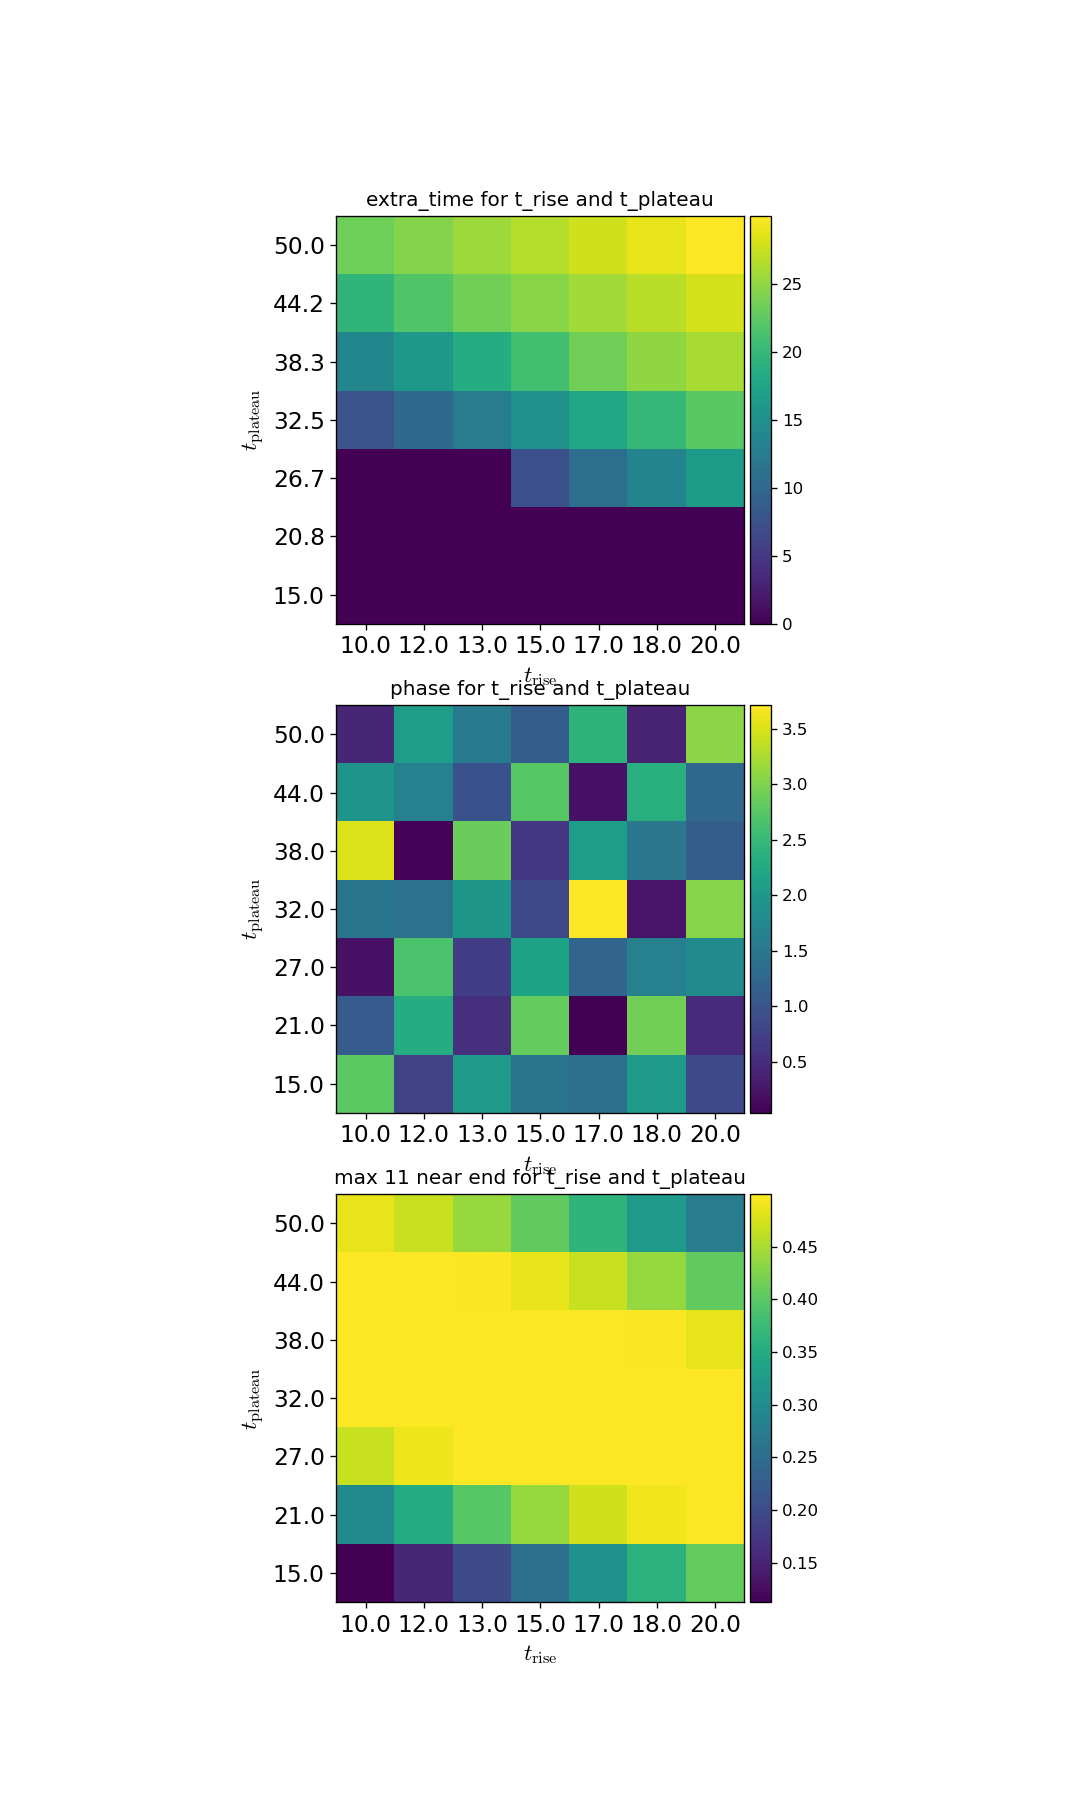

In [230]:
fig, ax = plt.subplots(3, 1, figsize = (9, 15))

im0 = ax[0].imshow( scann_extra_times[:,::-1 ].T)

ax[0].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[0].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[0].set_title('extra_time for t_rise and t_plateau')

ax[0].set_xticks(range(n_rise))
ax[0].set_yticks(range(n_plateau))
ax[0].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[0].set_yticklabels(np.round(rg_t_plateau, 1)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')



im1 = ax[1].imshow(scann_phases_abs[:,::-1 ].T)

ax[1].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[1].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[1].set_title('phase for t_rise and t_plateau')

ax[1].set_xticks(range(n_rise))
ax[1].set_yticks(range(n_plateau))
ax[1].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[1].set_yticklabels(np.round(rg_t_plateau)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')




im2 = ax[2].imshow(scann_max_11[:,::-1 ].T)

ax[2].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[2].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[2].set_title('max 11 near end for t_rise and t_plateau')

ax[2].set_xticks(range(n_rise))
ax[2].set_yticks(range(n_plateau))
ax[2].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[2].set_yticklabels(np.round(rg_t_plateau)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


### 1D scann

In [219]:
#1D scann:
t_tot = 58.3

n_rise_1D = 10
rg_t_rise_1D = np.linspace(17, 18.3, n_rise_1D)

n_t_tot = 3
rg_t_tot_1D = np.linspace(t_tot - .1, t_tot + .1, n_t_tot)

scann_extra_times_1D = np.zeros((n_rise_1D, n_t_tot))
scann_phases_1D = np.zeros((n_rise_1D, n_t_tot))
scann_max_11_1D = np.zeros((n_rise_1D, n_t_tot))

deb_test = time.time()
optim_drive(np.mean(rg_t_rise_1D), np.mean(rg_t_tot_1D) - 2*np.mean(rg_t_rise_1D))
length_test = time.time() - deb_test
print("Loops should take ", length_test*n_rise_1D*n_t_tot, "seconds  ; End around", 
              datetime.datetime.now() + datetime.timedelta(seconds = length_test*n_rise_1D*n_t_tot))

Loops should take  347.17952728271484 seconds  ; End around 2021-06-03 12:46:57.097248


In [220]:
for a in range(n_rise_1D):
    for b in range(n_t_tot):
        scann_extra_times_1D[a, b], scann_phases_1D[a, b], scann_max_11_1D[a, b] = optim_drive(rg_t_rise_1D[a], rg_t_tot_1D[b] - 2*rg_t_rise_1D[a] )
    
%notify

<IPython.core.display.Javascript object>

In [221]:
scann_phases_1D_abs = np.abs(scann_phases_1D)

<IPython.core.display.Javascript object>


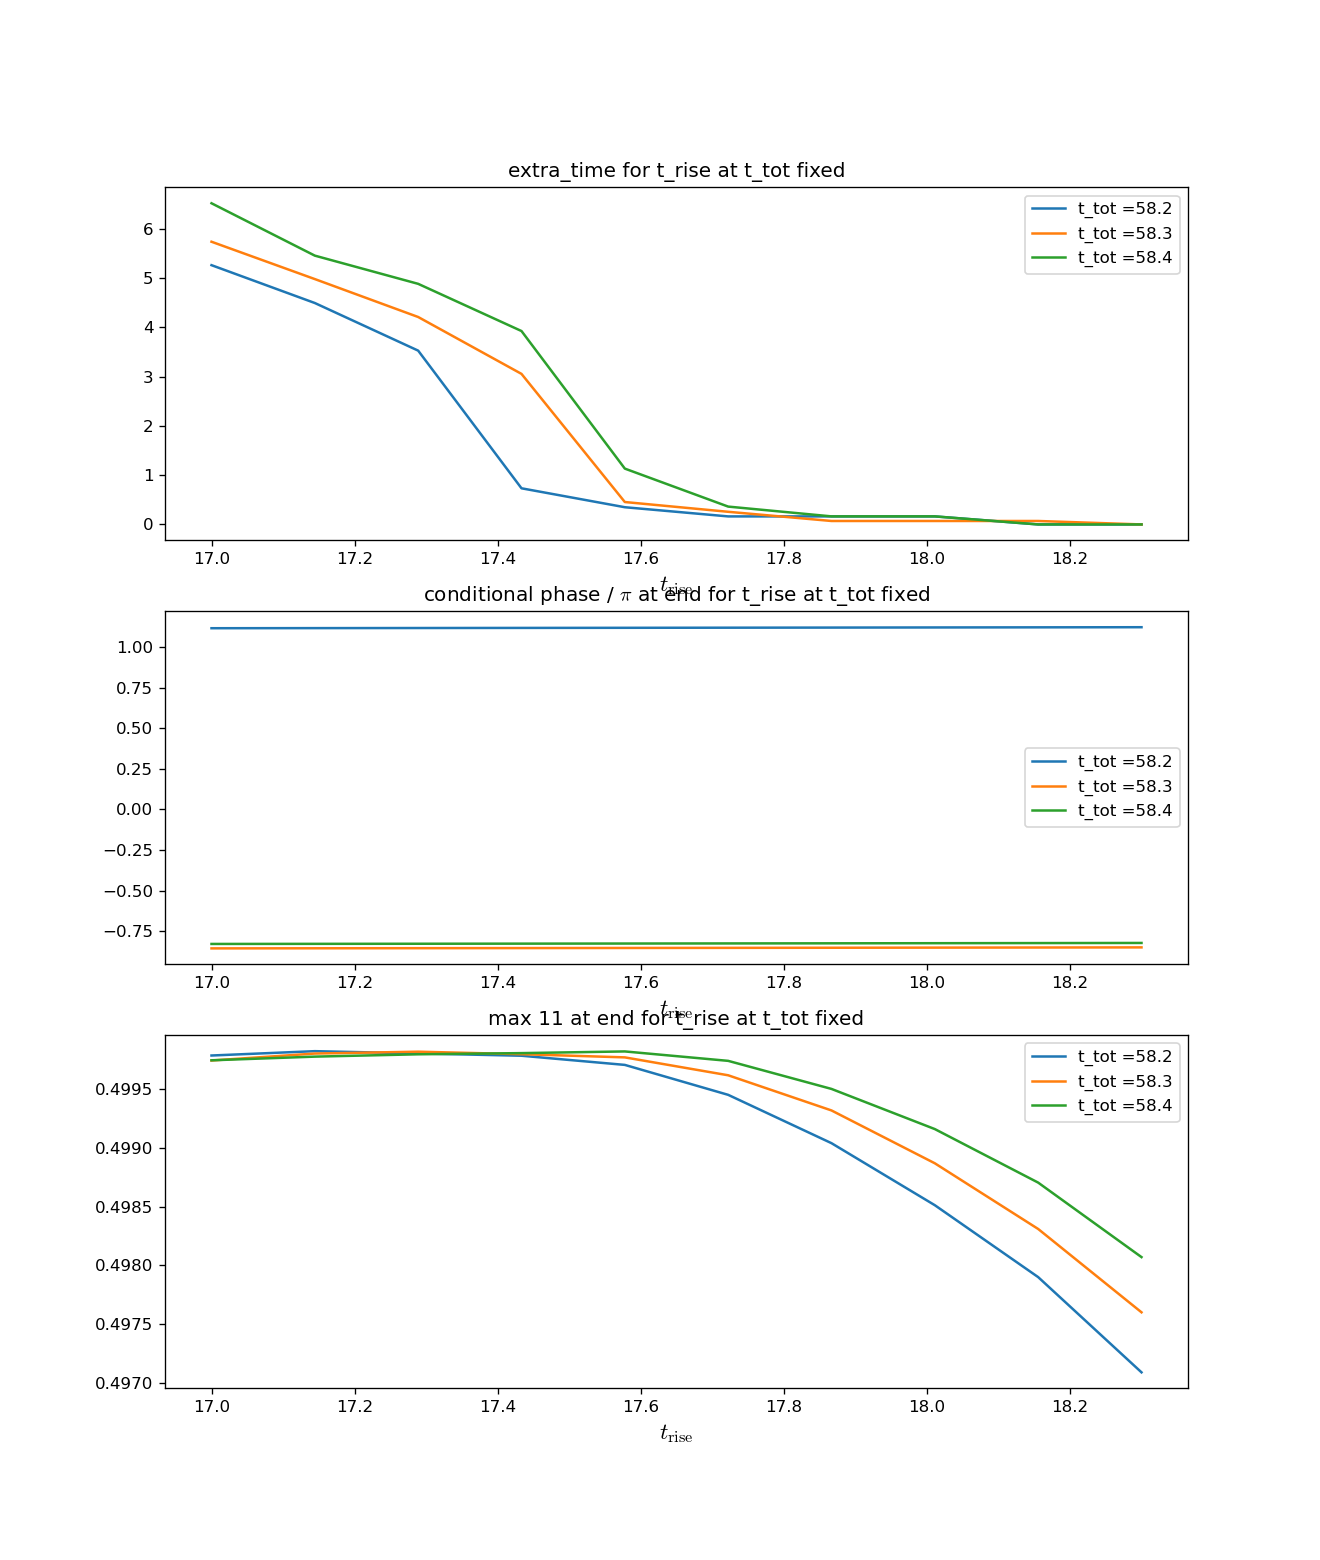

In [234]:
fig, ax = plt.subplots(3, 1, figsize = (11, 13))

for b in range(n_t_tot):
    ax[0].plot(rg_t_rise_1D, scann_extra_times_1D[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
        # ax[1].plot(rg_t_rise_1D, scann_phases_1D_abs[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
    ax[1].plot(rg_t_rise_1D, scann_phases_1D[:,b]/np.pi, label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
    ax[2].plot(rg_t_rise_1D, scann_max_11_1D[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
        
ax[0].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[0].set_title('extra_time for t_rise at t_tot fixed')
ax[0].legend()

ax[1].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[1].set_title('conditional phase / $\pi$ at end for t_rise at t_tot fixed')
ax[1].legend()

ax[2].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[2].set_title('max 11 at end for t_rise at t_tot fixed')
ax[2].legend()


### Study of best spot

In [165]:
# ind_i = 5
# ind_j = 1
# print(rg_t_rise_1D[ind_i])
# scann_extra_times_1D[ind_i, ind_j], scann_phases_1D[ind_i, ind_j], scann_max_11_1D[ind_i, ind_j]

# t_rise_best = rg_t_rise[ind_i]
# t_plateau_best = rg_t_tot_1D[ind_j] - 2*rg_t_rise_1D[ind_i]

t_rise_best = 17.6
t_tot_best = 58.3
t_plateau_best = t_tot_best - 2*t_rise_best

17.72222222222222


<IPython.core.display.Javascript object>


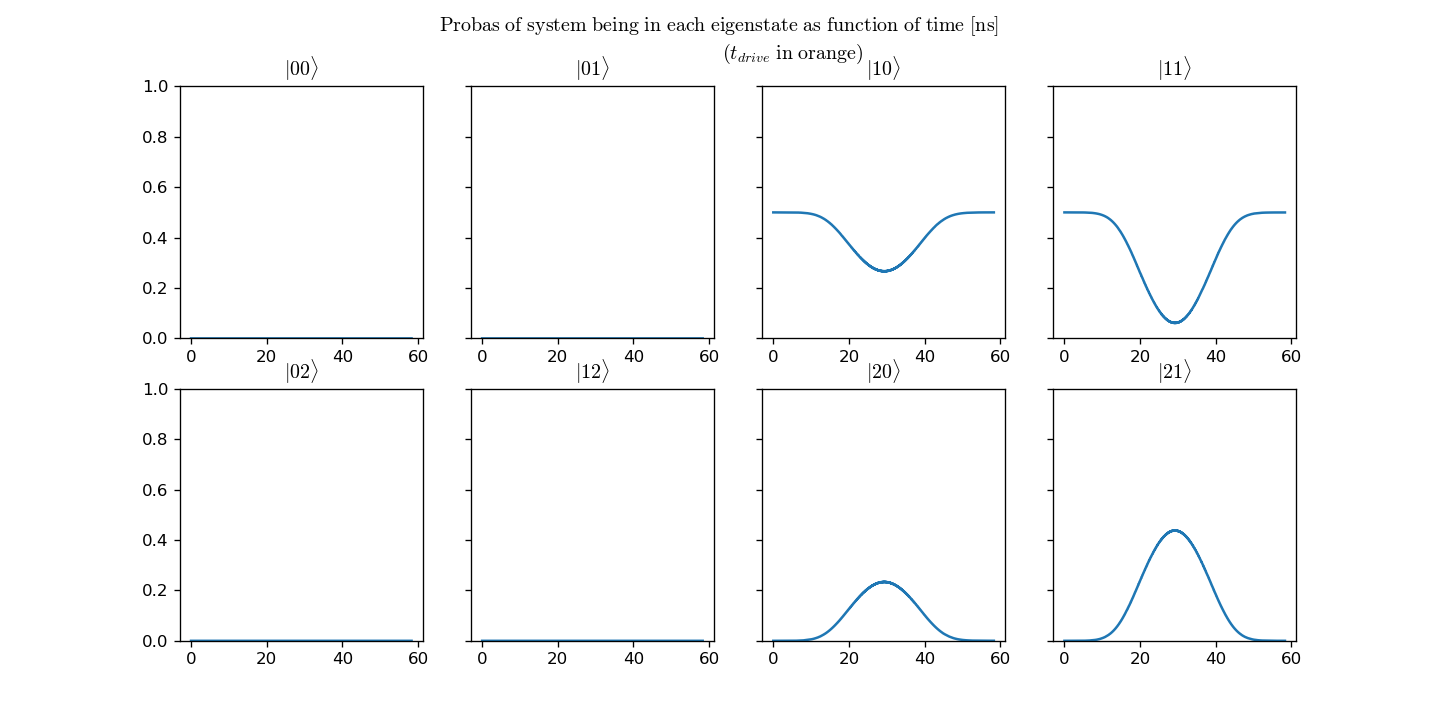

<IPython.core.display.Javascript object>


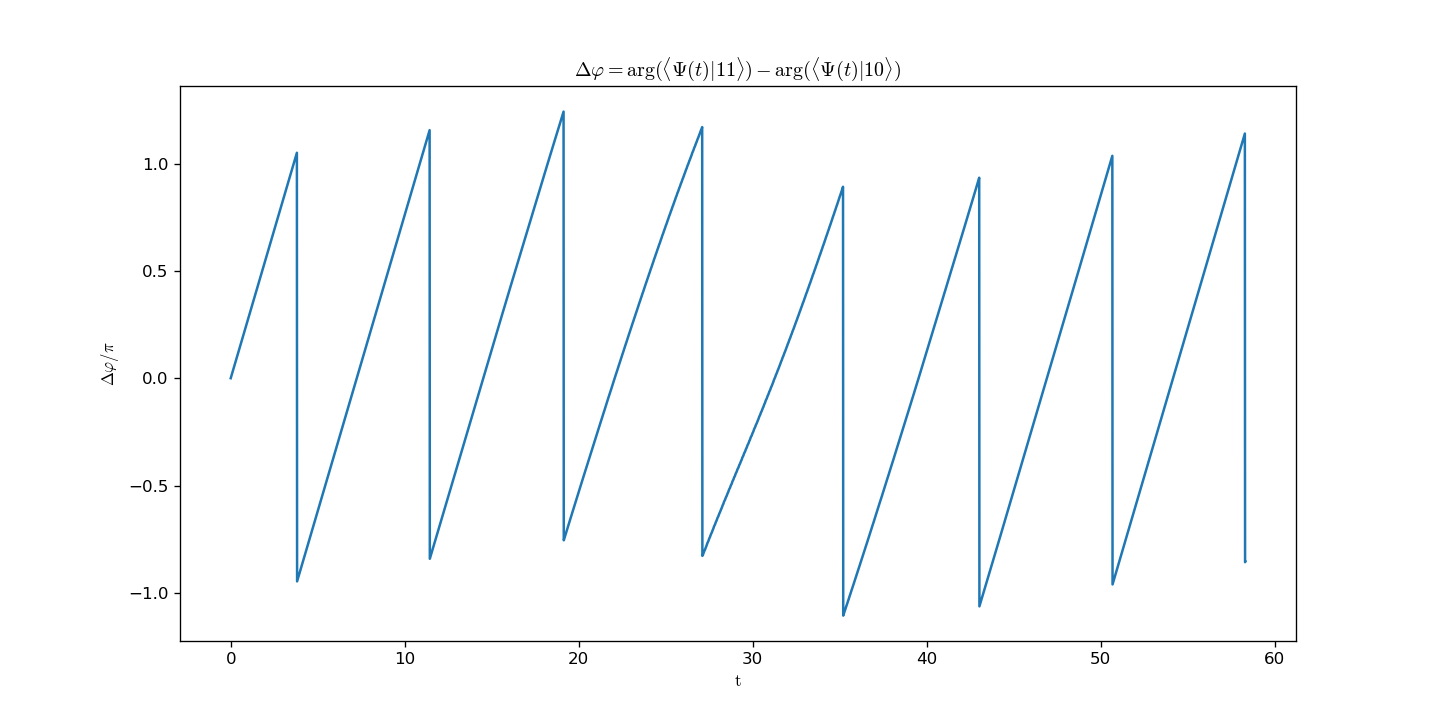

In [235]:
dt, phase_cond, max_prob = optim_drive(t_rise_best, t_plateau_best,
           plot_proba=True, plot_phase_cond=True)

In [173]:
print("Parameters : t_plateau_best =", t_plateau_best, "  and t_rise_best =", t_rise_best)
print("Final phase : ", np.round(phase_cond/np.pi, 2), "x pi")
print("proba_finale : ", max_prob*2 )

Parameters : t_plateau_best = 23.099999999999994   and t_rise_best = 17.6
Final phase :  -0.85 x pi
proba_finale :  0.999498138810954


## Optimisation in t_rise and t_plateau (scipy.optimize)

In [232]:
def optim_drive_rise_plateau_wgt(times, eta = eta_test, pts_per_drive_period = 15,
                                 plot_proba = False, plot_phase_cond = False, mute = True):
    t_rise = times[0]
    t_plateau = times[1]
    
    
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                      eta = eta,
                                      freq_drive = None,
                                      freq_drive_trans = None,
                                      plateau_time = t_plateau,
                                      rise_time = t_rise,
                                      with_drive = True,
                                      pts_per_drive_period = pts_per_drive_period,
                                      plot_spectrum = False,
                                      plot_proba = plot_proba, 
                                      plot_phase = False, 
                                      plot_proj = False, 
                                      plot_phase_cond = plot_phase_cond,
                                      figsize = (12, 6),
                                      mute = mute)
    
#     tlist = tlist/(2*np.pi)
#     extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    
    accumulated_phase_minus_pi = (dphi[-1] - dphi[0] - np.pi)%(2*np.pi) /np.pi
    
    leakage_11 = 1 - dict_res['probs'][3][-1]/dict_res['probs'][3][0]
#     leakage_min = 1 - np.max(dict_res['probs'][3][2*len(tlist)//3 :])/dict_res['probs'][3][0]
    
    
#     weight = leakage_11 + np.sqrt(np.abs(accumulated_phase_minus_pi)) #sqrt because increases values smaller than 1
    weight = np.sqrt(np.abs(leakage_11)) + np.sqrt(np.abs(accumulated_phase_minus_pi))
              
    return weight

def optim_drive_rise_tot_wgt(times, eta = eta_test, pts_per_drive_period = 15,
                             plot_proba = False, plot_phase_cond = False, mute = True):
    return optim_drive_rise_plateau_wgt([times[0], times[1] + 2*times[0]], eta, pts_per_drive_period,
                                        plot_proba, plot_phase_cond, mute)

In [233]:
t_rise_init = 15
t_plateau_init = 25
t_tot_init = t_rise_init*2 + t_plateau_init

init_rise_plateau = [t_rise_init, t_plateau_init]
init_rise_tot = [t_rise_init ,t_tot_init]

manual_x = [t_rise_best, t_plateau_best]

deb = time.time()
print("Init weight is : ", optim_drive_rise_plateau_wgt(init_rise_plateau, pts_per_drive_period = 15,
                                                        plot_proba = False, plot_phase_cond = False))
print("Best weight found before is :", optim_drive_rise_plateau_wgt(manual_x))

print("Loop should take about ", (time.time() - deb)/2 , " per iteration")

Init weight is :  0.13565832816269077
Best weight found before is : 0.12959661709241016
Loop should take about  9.873998284339905  per iteration


In [237]:
opt = minimize(optim_drive_rise_plateau_wgt, init_rise_plateau,
               method='L-BFGS-B',
               bounds=[(3, 40), (13, 80)],
               callback = quality_indices_rise_plateau,
               options={'iprint' : 1000,  'maxfun' : 40}
              )

#to param by rise and tot (because for same total time, leakage is similar)
# opt = minimize(optim_drive_rise_tot, init_rise_tot,
#                method='trust-constr',
#                bounds=[(0, 100), (0, 100)],
#                options={'verbose': 2, 'maxiter' : 240}
#               )

print(opt.message)
%notify

leakage of 11 = 0.0019818702348346484
accumulated phase :  3.16180358213689
leakage of 11 = 0.0016679574983254897
accumulated phase :  3.1560441151840464
leakage of 11 = 0.001120261219765939
accumulated phase :  3.1578508910878678
leakage of 11 = 0.0009901726445942227
accumulated phase :  3.1582712970797604
leakage of 11 = 0.000984278250080406
accumulated phase :  3.1582815266845774
leakage of 11 = 0.001039288997777943
accumulated phase :  3.157407941552923


<IPython.core.display.Javascript object>

In [239]:
print(opt.message)

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


In [238]:
wgt_opt = opt.fun

t_rise_opt = opt.x[0]
t_plateau_opt = opt.x[1]
t_tot_opt = t_rise_opt*2  +  t_plateau_opt

print("Optimized value gives of :", wgt_opt, "\nFor t_rise =", t_rise_opt,
                                              " and t_plateau =", t_plateau_opt, 
                                             " \nSo t_tot =", t_tot_opt)

Optimized value gives of : 0.10318983782065795 
For t_rise = 15.133747239570411  and t_plateau = 25.54141236924457  
So t_tot = 55.80890684838539


In [236]:
def quality_indices_rise_plateau(times, eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True):
    t_rise = times[0]
    t_plateau = times[1]
    
    
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                      eta = eta,
                                      freq_drive = None,
                                      freq_drive_trans = None,
                                      plateau_time = t_plateau,
                                      rise_time = t_rise,
                                      with_drive = True,
                                      pts_per_drive_period = 15,
                                      plot_spectrum = False,
                                      plot_proba = plot_proba, 
                                      plot_phase = False, 
                                      plot_proj = False, 
                                      plot_phase_cond = plot_phase_cond,
                                      figsize = (12, 6),
                                      mute = mute)
    
    tlist = tlist/(2*np.pi)
    extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    
    acc_phase = (dphi[-1] - dphi[0])%(2*np.pi)
    
    leakage_11 = 1 - dict_res['probs'][3][-1]/dict_res['probs'][3][0]
#     leakage_min = 1 - np.max(dict_res['probs'][3][2*len(tlist)//3 :])/dict_res['probs'][3][0]
    
    
#     if not mute :
    print("leakage of 11 =", leakage_11)  #must go to 0
    print("accumulated phase / \pi: ", acc_phase/np.pi)  #must go to pi (or -pi)

#     print("It took ", time.time() - deb , "seconds")
              
    return acc_phase/np.pi, leakage_11, extra_time

def  quality_indices_rise_tot(times, eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True):
    return  quality_indices_rise_plateau([times[0], times[1] + 2*times[0]], 
                                         eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True)

In [209]:
init_rise_plateau = [t_rise_init, t_plateau_init]
init_rise_tot = [t_rise_init ,t_plateau_init]
init_rise_opt = [t_rise_opt ,t_plateau_opt]

def print_quality(t_rise, t_plateau, name):
    acc_phase, leakage, extra_time =  quality_indices_rise_plateau([t_rise, t_plateau])
    print("The "+name+" parameters are : t_rise =", t_rise, " ; t_plateau =", t_plateau,
          "\nThe quality indices are : acc_phase/pi =", acc_phase, " ; leakage_11 =", 
          leakage*100, "% ; extra_time =", extra_time)

print_quality(t_rise_init, t_plateau_init, 'init')
print("\n ----- \n")
print_quality(t_rise_best, t_plateau_best, 'manually obainted best')
print("\n ----- \n")
print_quality(t_rise_opt, t_plateau_opt, 'algorithmically optimized')

The init parameters are : t_rise = 15  ; t_plateau = 25 
The quality indices are : acc_phase/pi = 1.0067736882239837  ; leakage_11 = 0.28468530096881217 % ; extra_time = 0.14109141791044522

 ----- 

The manually obainted best parameters are : t_rise = 17.6  ; t_plateau = 23.099999999999994 
The quality indices are : acc_phase/pi = 1.0092742183569419  ; leakage_11 = 0.11084820356187519 % ; extra_time = 0.25654565456545697

 ----- 

The algorithmically optimized parameters are : t_rise = 15.781289521134324  ; t_plateau = 63.96994407360842 
The quality indices are : acc_phase/pi = 0.005374832645781021  ; leakage_11 = 0.20068287374249705 % ; extra_time = 1.628759623535558


## Analysis of best case scenario

r = 1.3199903366213783

delta/Delta = 0.30704956167928665

Big Delta =  0.02546960120165842
small delta =  0.00782042988511545

Rabi period: 39.26249147296764 [ns]

Drive frequency fd: 5.199158795956893 [GHz]


<IPython.core.display.Javascript object>


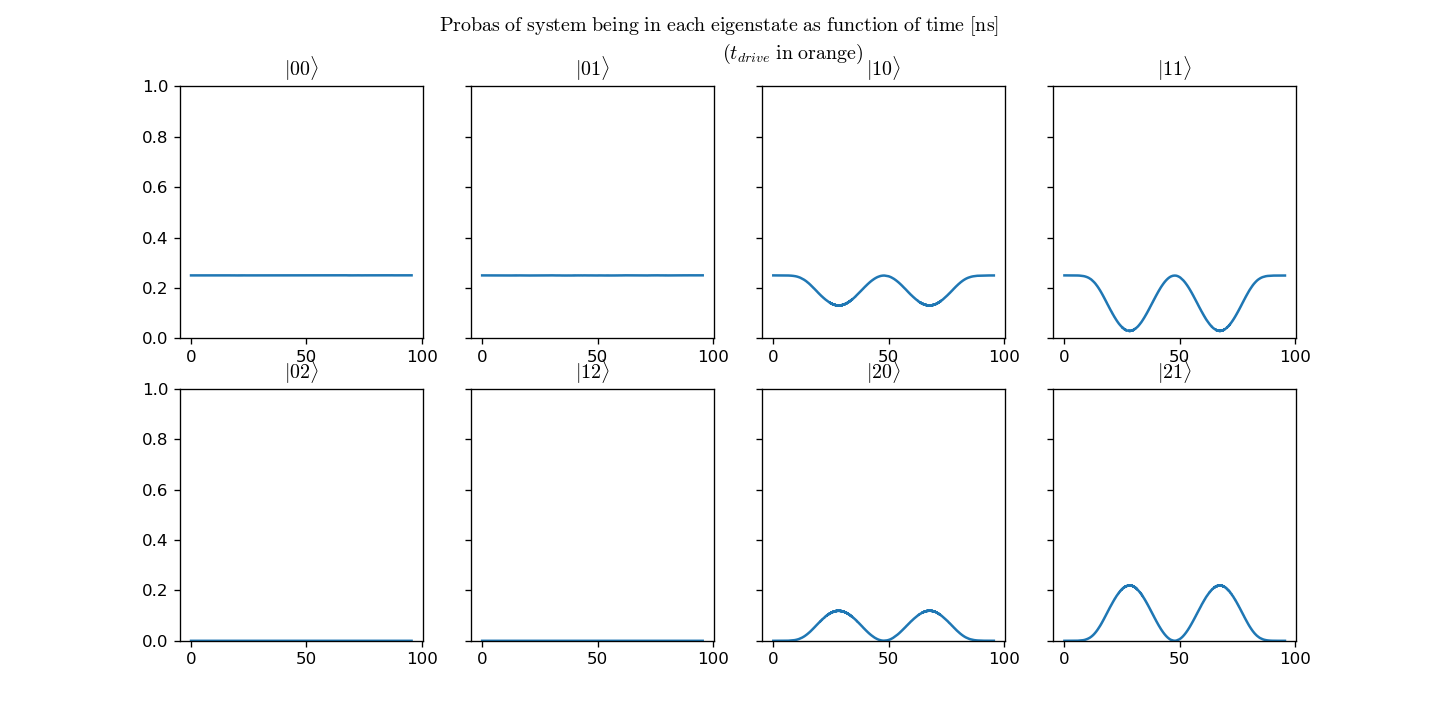

<IPython.core.display.Javascript object>


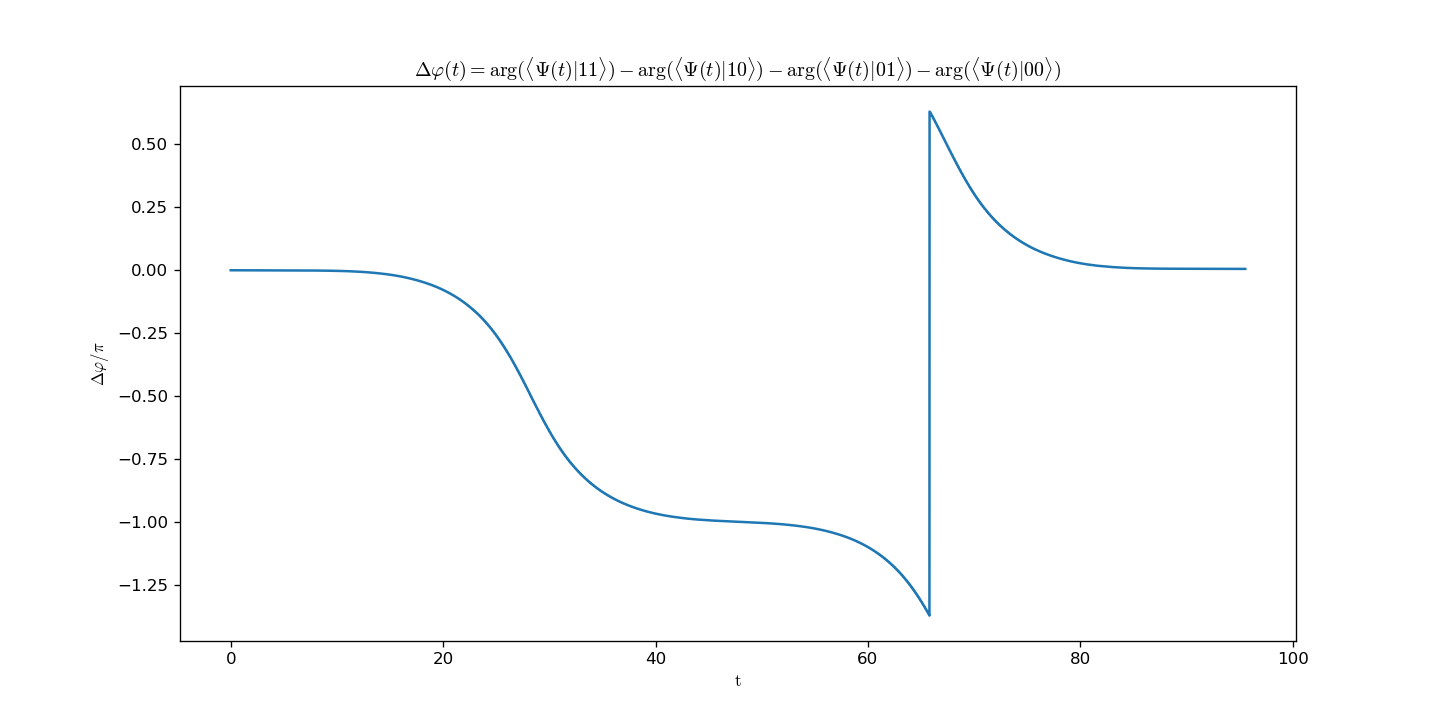

It took  16.108325958251953 seconds


In [210]:
deb = time.time()

tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                  eta = eta_test,
                                  freq_drive = None,
                                  freq_drive_trans = None,
                                  plateau_time = t_plateau_opt,
                                  rise_time = t_rise_opt,
                                  with_drive = True,
                                  pts_per_drive_period = 15,
                                  plot_spectrum = False,
                                  plot_proba = True, 
                                  plot_phase = False, 
                                  plot_proj = False, 
                                  plot_phase_cond = True,
                                  mute = False,
                                  figsize = (12, 6))

print("It took ", time.time() - deb , "seconds")

In [ ]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['probs'][3])

## Impact of errors in parameters

In [141]:
def test_entry_errors(x, nb_tests, test_function, error_function, error_str, title_names = [], plot = False): 
    '''error_function takes no ergument and 
            returns a array of same size as x that  will be applied to x (for no error : it returns only ones)
            
        test_function is the function thta takes x in argument and returns the quantities of interest'''
    
    entry_param = np.zeros((nb_tests, len(x)))
    quality_indices = np.zeros((nb_tests, len(test_function(x))))
    
    if plot: #before long calculations to save time
        assert len(title_names) == 2
        assert len(title_names[0]) == len(entry_param[0])
        assert len(title_names[1]) == len(quality_indices[0])
        
    for a in range(nb_tests):
        entry_param[a, :] = error_function() * np.array(x)
        quality_indices[a,:] = test_function(entry_param[a,:])
        
    if plot:
        fig, ax = plt.subplots(1, len(entry_param[0]), figsize = (12, 5))
        fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
        for k in range(len(entry_param[0])):
            ax[k].hist(entry_param[:, k], bins='auto')#,histtype='step',)
            ax[k].set_title(title_names[0][k])
        plt.show()


        fig, ax = plt.subplots(1, len(entry_param[1]), figsize = (12, 5))
        fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
        for k in range(len(entry_param[1])):
            ax[k].hist(quality_indices[:, k], bins='auto')#,histtype='step',)
            ax[k].set_title(title_names[1][k])
        plt.show()
        
    return entry_param, quality_indices

In [146]:
sigma = .05
def gaussian_error_rise_plateau():
    return np.random.normal(loc = 1, scale = sigma, size = 2)

names = [["t_rise", "t_plateau"], ["acc_phase", "leakage_11", "extra_time"]]
error_str = "a gaussian error of sigma ="+str(sigma)

time_param, qual_ind  = test_entry_errors(x = [t_rise_opt, t_plateau_opt],
                                             nb_tests = 100, 
                                             test_function = quality_indices_rise_plateau,
                                             error_function = gaussian_error_rise_plateau,
                                             error_str = error_str,
                                             title_names = names, 
                                             plot = True)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


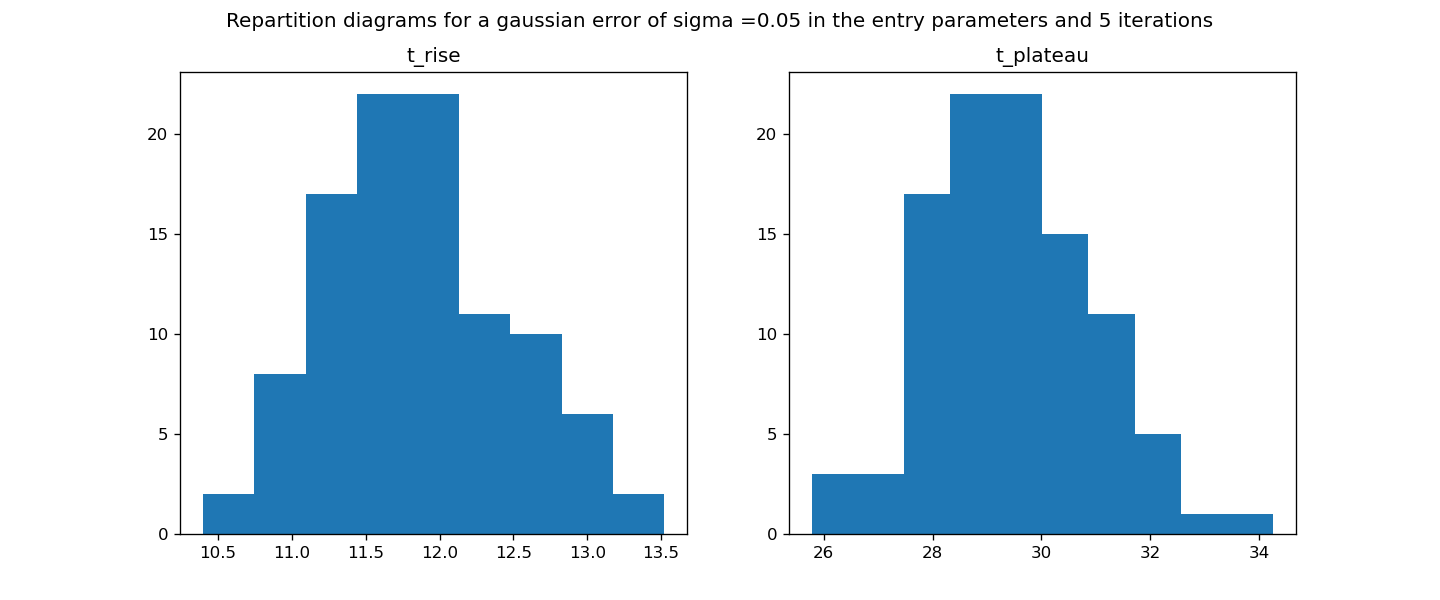

<IPython.core.display.Javascript object>


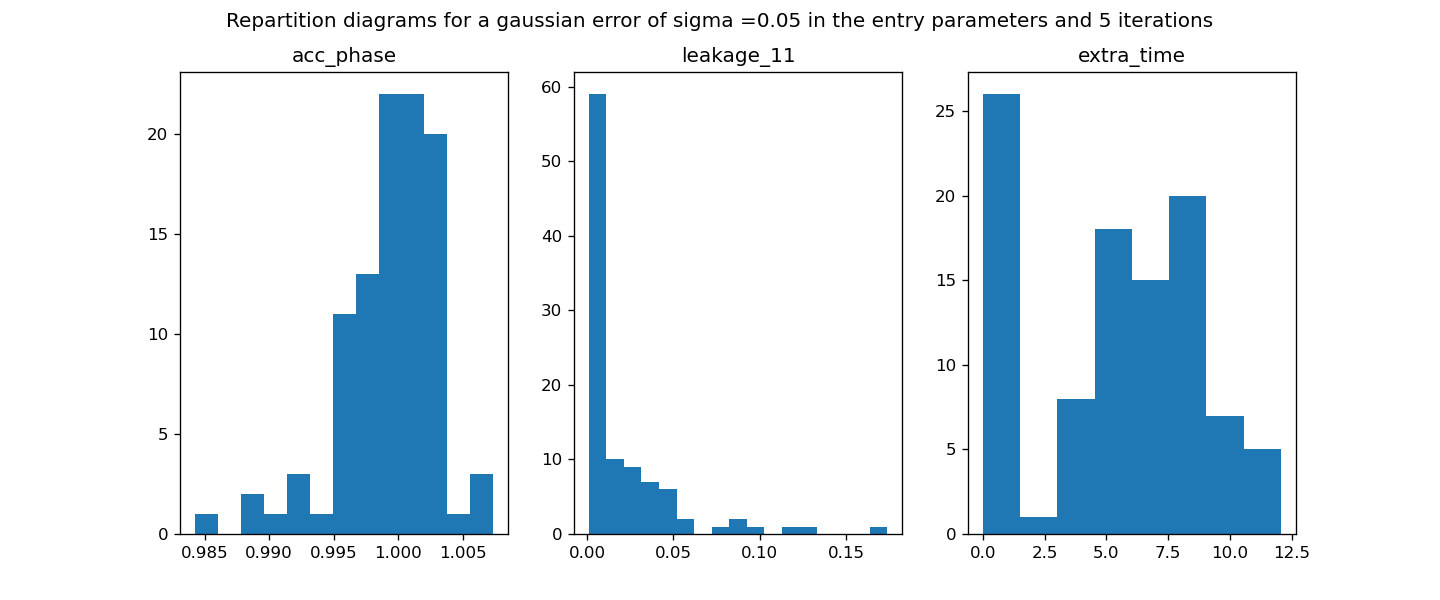

In [155]:
entry_param = time_param
quality_indices = qual_ind

fig, ax = plt.subplots(1, len(entry_param[0]), figsize = (12, 5))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(entry_param[0])):
    ax[k].hist(entry_param[:, k], bins='auto')#,histtype='step',)
    ax[k].set_title(names[0][k])
plt.show()


fig, ax = plt.subplots(1, len(quality_indices[1]), figsize = (12, 5))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(quality_indices[1])):
    ax[k].hist(quality_indices[:, k], bins='auto')#,histtype='step',)
    ax[k].set_title(names[1][k])
plt.show()

<IPython.core.display.Javascript object>


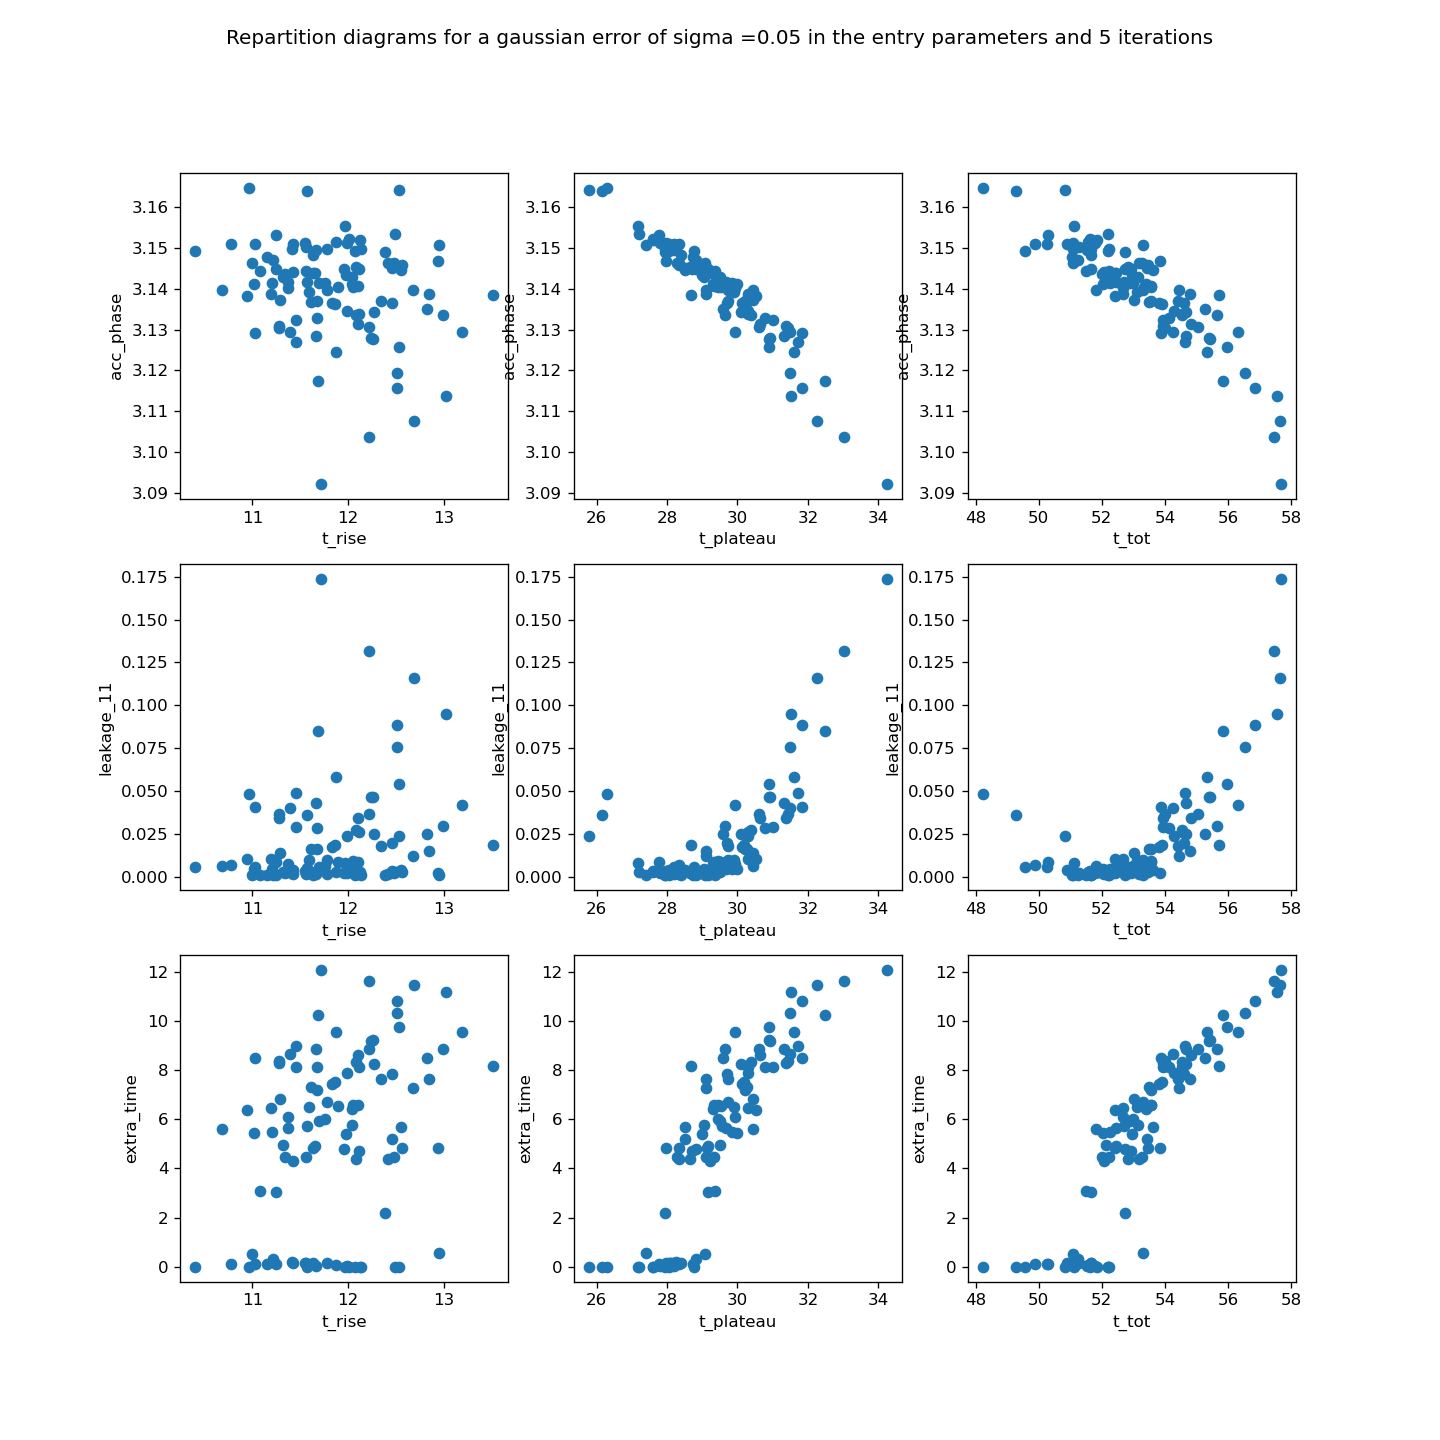

In [153]:
fig, ax = plt.subplots(len(quality_indices[0]), len(entry_param[0])+1, figsize = (12, 12))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(entry_param[0])):
    for l in range(len(quality_indices[0])):
        ax[l, k].scatter(entry_param[:, k], quality_indices[:, l])
        ax[l, k].set_xlabel(names[0][k])
        ax[l, k].set_ylabel(names[1][l])
        
for l in range(len(quality_indices[0])):
        ax[l, 2].scatter(2*entry_param[:, 0] + entry_param[:, 1], quality_indices[:, l])
        ax[l, 2].set_xlabel("t_tot")
        ax[l, 2].set_ylabel(names[1][l])
plt.show()

In [144]:
%notify

<IPython.core.display.Javascript object>

## Leakage

In [339]:
def leakage(jc = .224, eta = eta_test, list_init=  [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]],
                freq_drive = None, freq_drive_trans = None,
               t_points = 2000, plateau_time = None, rise_time = None, with_drive = True,
               plot_spectrum = False,plot_proba = False, plot_phase = False, plot_proj = False, plot_phase_cond = True,
                mute = True, figsize = (12, 6)):
    
    dict_res = test_simu(jc = jc, 
                              eta = eta,
                              list_init = list_init,
                              freq_drive = freq_drive,
                              freq_drive_trans = freq_drive_trans,
                              plateau_time = plateau_time,
                              rise_time = rise_time,
                              with_drive = with_drive,
                              plot_spectrum = plot_spectrum,
                              plot_proba = plot_proba, 
                              plot_phase = plot_phase, 
                              plot_proj = plot_proj,
                              mute = mute,
                              t_points = t_points,
                              figsize = figsize)
    

    leakage = 1 - sum(dict_res['probs'][:4, -1])
    
    print("Leakage at the end of the total simulation time is : "+ str(leakage*100) + "%")
    return leakage

In [340]:
leakage_00_01_10_11 = leakage(jc = .224, 
                              eta = eta_test, 
                              list_init=  [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]],
                              freq_drive = None, 
                              freq_drive_trans = None,
                              t_points = 5000, 
                              plateau_time = t_plateau_best, 
                              rise_time = t_rise_best, 
                              with_drive = True,
                              plot_spectrum = False,
                              plot_proba = False, 
                              plot_phase = False, 
                              plot_proj = False, 
                              plot_phase_cond = False,
                              mute = True, 
                              figsize = (12, 6))

Leakage at the end of the total simulation time is : 0.011114330058448196%


# Tomography (not tackled yet)

In [37]:
def gate_function(state_in, **kwargs):
    t_points = kwargs['t_points']
    tlist = np.linspace(0, kwargs['t_max'], t_points)
    rho_in = state_in*state_in.dag()
    hamil0 = kwargs['hamil0']
    hamil_drive = kwargs['hamil_drive']
                                  
    pulse_drive = np.cos(kwargs['freq_drive']*tlist)

    result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

    end_state = result.states[-1]
    return end_state

In [38]:
param_dict = {
    't_points' : 10000 ,
    't_max' : t_drive,
    'hamil0' : coupled_flx.hamiltonian(as_qobj=True),
    'hamil_drive' : qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True),
    'freq_drive' : freq_drive
}

In [39]:
import pysqkit.tomography.utilsTomo as tomo

In [40]:
fct = tomo.rid_of_dict(gate_function,param_dict)
nb_levels = [3,3]

In [41]:
deb =  time.time()
lambda_mat = tomo.fct_to_lambda(fct, nb_levels, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

ValueError: incompatible Liouvillian and state dimensions: [[[5, 5], [5, 5]], [[5, 5], [5, 5]]] and [[3, 3], [3, 3]]

In [ ]:
deb =  time.time()
chi_mat = tomo.lambda_to_chi(lambda_mat, nb_levels, draw_chi = True )
print("It took" , time.time() - deb, "seconds")

In [ ]:
lambda_mat_2lev = np.zeros((16, 16))*1j

for i in range(16):
    for j in range(16):
        ani, bni, ami, bmi = tomo._n_th([2, 2, 2, 2], i) #i is |ani bni><ami bmi|
        anj, bnj, amj, bmj = tomo._n_th([2, 2, 2, 2], j)
        
        lambda_mat_2lev[i,j] = lambda_mat[ani*27 + bni * 9 + ami * 3 + bmi][anj*27 + bnj * 9 + amj* 3 + bmj]

In [ ]:
tomo.draw_mat(lambda_mat_2lev, "\lambda^2")

In [ ]:
chi_mat_2lev = tomo.lambda_to_chi(lambda_mat_2lev, [2,2], draw_chi = True)

chi_CZ = np.zeros((16,16))
chi_CZ[0,0] = 1
chi_CZ[0,3] = 1
chi_CZ[3,0] = 1
chi_CZ[3,3] = 1

chi_CZ[0,12] = 1
chi_CZ[3,12] = 1
chi_CZ[0,15] = -1
chi_CZ[3,15] = -1

chi_CZ[12,12] = 1
chi_CZ[15,12] = -1
chi_CZ[12,15] = -1
chi_CZ[15,15] = 1

chi_CZ[12,0] = 1
chi_CZ[12,3] = 1
chi_CZ[15,0] = -1
chi_CZ[15,3] = -1

tomo.draw_mat(chi_CZ, "\chi^{CZ}")